# Trabalho de conclusão de curso - Big data e Ciências de Dados PUC-Minas

@autor: Guilherme Nathanli Ribeiro Beserra

# 1 - Classificação para predição de vítima fatal em acidente aéreo

Iremos analisar as ocorrências de acidentes/incidentes aéreos que ocorreram no período de 2010 a 2019 no Brasil.

O Objetivo é classificar, a partir de uma dada ocorrência, se ela contém pelo menos 1 (uma) vítmia fatal ou não, ou seja, se em dado acidente/incidente observa-se fatalidade ou não.

## 2 - Coleta de Dados


Serão utilizadas as bases de dados fornecidas pelo Centro de Investigação e Prevenção de Acidentes Aeronáuticos (CENIPA), orgão responsável pela investigação de todos os acidentes ou incidentes aéreos no país.

Os dados estão disponíveis em: https://dados.gov.br/dataset/ocorrencias-aeronauticas-da-aviacao-civil-brasileira

Vamos utilizar as tabelas disponíveis em formato CSV: aeronave.csv, fator_contribuinte.csv, ocorrencia.csv e ocorrencia_tipo.csv, conforme o modelo de dados: 

<p align="center"><img src="https://github.com/guilherme-beserra/TCC---PUC-Minas/blob/main/imagens/modelo_dados-editada.jpg?raw=true" width="100%"></p>


Ao longo deste notebook, as tabelas OCORRÊNCIA, FATOR_CONTRIBUINTE, AERONAVE e OCORRENCIA_TIPO e RECOMENDAÇÃO serão analisadas e verificada a possibilidade  de que todas sejam unificadas (conforme especificação do modelo).
Na coluna ``aeronave_fatalidade_total`` da tabela AERONAVE (``aeronave.csv``) iremos associar 0 se não houve nenhuma vítima fatal (total igual a zero) e 1 caso contrário (total de vítimas igual a 1 ou mais).

Também serão utilizadas as tabelas oriundas IBGE dos estados (``estados.csv``) e municípios (``municipios.csv``) contendo as latitudes e longitudes dos municípios para posterior preenchimento das latitudes e longitudes ausentes ou inconsistentes presentes nas ocorrências dos acidentes e incidentes aéreos. Os arquivos ``.csv`` de foram obtidos a partir do trabalho realizado por Leonardo Diegues que formatou os dados brutos do IBGE: https://github.com/kelvins/Municipios-Brasileiros/blob/main/csv

<p align="center"><img src="https://github.com/guilherme-beserra/TCC---PUC-Minas/blob/main/imagens/modelo_estados_municipios_ibge.jpg?raw=true" width="50%"></p>


In [253]:
from platform import python_version
print('Versão Python utilizada:', python_version())

Versão Python utilizada: 3.8.5


In [254]:
# import warnings filter
from warnings import simplefilter
# ignore all future warnings
simplefilter(action='ignore', category=FutureWarning)

# importando os pacotes necessários
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import roc_auc_score, roc_curve, accuracy_score
from sklearn.metrics import balanced_accuracy_score
import numpy as np
pd.set_option("display.max_columns", None)


In [255]:
# importando a tabela ocorrencia.csv
caminho_ocorrencia = "https://raw.githubusercontent.com/guilherme-beserra/TCC---PUC-Minas/main/dados/ocorrencia.csv"
df_ocorrencia = pd.read_csv(caminho_ocorrencia, sep=';')

# monstrando as 5 primeiras entradas
df_ocorrencia.head()

,codigo_ocorrencia,codigo_ocorrencia1,codigo_ocorrencia2,codigo_ocorrencia3,codigo_ocorrencia4,ocorrencia_classificacao,ocorrencia_latitude,ocorrencia_longitude,ocorrencia_cidade,ocorrencia_uf,ocorrencia_pais,ocorrencia_aerodromo,ocorrencia_dia,ocorrencia_hora,investigacao_aeronave_liberada,investigacao_status,divulgacao_relatorio_numero,divulgacao_relatorio_publicado,divulgacao_dia_publicacao,total_recomendacoes,total_aeronaves_envolvidas,ocorrencia_saida_pista
0,40211,40211,40211,40211,40211,INCIDENTE,***,***,RIO DE JANEIRO,RJ,BRASIL,****,03/01/2010,12:00:00,SIM,FINALIZADA,***,NÃO,NaN,0,1,NÃO
1,40349,40349,40349,40349,40349,INCIDENTE,NaN,NaN,BELÉM,PA,BRASIL,SBBE,03/01/2010,11:05:00,SIM,FINALIZADA,NaN,NÃO,NaN,0,1,NÃO
2,40351,40351,40351,40351,40351,INCIDENTE,NaN,NaN,RIO DE JANEIRO,RJ,BRASIL,SBRJ,03/01/2010,03:00:00,SIM,FINALIZADA,NaN,NÃO,NaN,0,1,NÃO
3,39527,39527,39527,39527,39527,ACIDENTE,-13.1066666667,-55.9930555556,LUCAS DO RIO VERDE,MT,BRASIL,****,04/01/2010,17:30:00,SIM,FINALIZADA,A-539/CENIPA/2018,SIM,2019-10-28,0,1,NÃO
4,40324,40324,40324,40324,40324,INCIDENTE,NaN,NaN,PELOTAS,RS,BRASIL,SBPK,05/01/2010,19:25:00,SIM,FINALIZADA,NaN,NÃO,NaN,0,1,NÃO


In [256]:
# verificando os tipos dos dados
df_ocorrencia.dtypes

codigo_ocorrencia                  int64
codigo_ocorrencia1                 int64
codigo_ocorrencia2                 int64
codigo_ocorrencia3                 int64
codigo_ocorrencia4                 int64
ocorrencia_classificacao          object
ocorrencia_latitude               object
ocorrencia_longitude              object
ocorrencia_cidade                 object
ocorrencia_uf                     object
ocorrencia_pais                   object
ocorrencia_aerodromo              object
ocorrencia_dia                    object
ocorrencia_hora                   object
investigacao_aeronave_liberada    object
investigacao_status               object
divulgacao_relatorio_numero       object
divulgacao_relatorio_publicado    object
divulgacao_dia_publicacao         object
total_recomendacoes                int64
total_aeronaves_envolvidas         int64
ocorrencia_saida_pista            object
dtype: object

In [257]:
print("Valores únicos (por coluna):\n{}\n".format(df_ocorrencia.nunique()))

Valores únicos (por coluna):
codigo_ocorrencia                 6114
codigo_ocorrencia1                6114
codigo_ocorrencia2                6114
codigo_ocorrencia3                6114
codigo_ocorrencia4                6114
ocorrencia_classificacao             3
ocorrencia_latitude               2732
ocorrencia_longitude              2728
ocorrencia_cidade                 1133
ocorrencia_uf                       28
ocorrencia_pais                      1
ocorrencia_aerodromo               531
ocorrencia_dia                    3155
ocorrencia_hora                    982
investigacao_aeronave_liberada       3
investigacao_status                  2
divulgacao_relatorio_numero       1897
divulgacao_relatorio_publicado       2
divulgacao_dia_publicacao          217
total_recomendacoes                 17
total_aeronaves_envolvidas           3
ocorrencia_saida_pista               2
dtype: int64



### Dicionário de Variáveis da tabela ocorrência.csv

* `codigo_ocorrencia` - é o código-chave da ocorrência registrada pelo CENIPA quando algum acidente ou incidente ocorre.  
* `ocorrencia_classificacao` - indica se a ocorrência foi um acidente, incidente ou incidente grave.
* `ocorrencia_latitude` - indica a latitude da ocorrência.
* `ocorrencia_longitude` - indica a longitude da ocorrência.
* `ocorrencia_cidade` - a cidade brasileira onde foi registrada a ocorrência.
* `ocorrencia_uf` - sigla do estado onde foi registrada a ocorrência.
* `ocorrencia_pais` - o país onde foi registrada a ocorrência e neste caso a coluna apresenta apenas um valor, Brasil.
* `ocorrencia_aeródromo` - sigla do aeródromo onde se registrou a ocorrência.
* `ocorrencia_dia` - dia da ocorrência do acidente ou incidente.
* `ocorrencia_hora` - horário de Brasília da ocorrência.
* `investigacao_aeronave_liberada` - indica se a aeronave foi ou não liberada para investigação após o acidente ou incidente.
* `investigacao_status` - indica se a investigação foi encerrada ("SIM") ou ainda está pendente ("NÃO").
* `divulgacao_relatorio_numero` - código do relatório de investigação da ocorrência.
* `divulgacao_relatorio_divulgado` - indica se o relatório foi divulgado ("SIM") ou não ("NÃO").
* `divulgacao_relatorio_divulgado` - data de divulgação do relatório.
* `total_recomendacoes` - total de recomendações para a ocorrência.
* `total_aeronaves_envolvidas` - quantidade de aeronaes envolvidas na ocorrência.
* `ocorrencia_saida_pista` - indica se a aeronve saiu ("SIM") ou não ("NÃO").

In [258]:
# mostrando a quantidade de linhas e colunas
print("Número de linhas: ", df_ocorrencia.shape[0])
print("Número de colunas: ", df_ocorrencia.shape[1])

Número de linhas:  6114
Número de colunas:  22


Mostra que os valores das colunas de codigo_ocorrencia são iguais  e portanto será deixada apenas a coluna codigo_ocorrencia.

In [259]:
# verificando se os códigos da ocorrência são únicos
print("Valores únicos para código ocorrência: ", df_ocorrencia[['codigo_ocorrencia']].nunique())

Valores únicos para código ocorrência:  codigo_ocorrencia    6114
dtype: int64


Conforme observado, os valores das colunas contendo os códigos das ocorrências são únicos.

In [260]:
# importando a tabela ocorrencia_tipo.csv
caminho_ocorrencia_tipo = "https://raw.githubusercontent.com/guilherme-beserra/TCC---PUC-Minas/main/dados/ocorrencia_tipo.csv"
df_ocorrencia_tipo = pd.read_csv(caminho_ocorrencia_tipo, sep=';')

# monstrando as 5 primeiras entradas
df_ocorrencia_tipo.head()

,codigo_ocorrencia1,ocorrencia_tipo,ocorrencia_tipo_categoria,taxonomia_tipo_icao
0,39115,PANE SECA,COMBUSTÍVEL | PANE SECA,FUEL
1,39155,VAZAMENTO DE COMBUSTÍVEL,FALHA OU MAU FUNCIONAMENTO DE SISTEMA / COMPON...,SCF-NP
2,39156,FOGO EM VOO,FOGO/FUMAÇA (SEM IMPACTO) | FOGO EM VOO,F-NI
3,39158,SUPERAQUECIMENTO,FALHA OU MAU FUNCIONAMENTO DO MOTOR | SUPERAQU...,SCF-PP
4,39176,FALHA OU MAU FUNCIONAMENTO DE SISTEMA / COMPON...,FALHA OU MAU FUNCIONAMENTO DE SISTEMA / COMPON...,SCF-NP


In [261]:
# verificando os tipos dos dados
df_ocorrencia_tipo.dtypes

codigo_ocorrencia1            int64
ocorrencia_tipo              object
ocorrencia_tipo_categoria    object
taxonomia_tipo_icao          object
dtype: object

### Dicionário de Variáveis da tabela ocorrencia_tipo

* `codigo_ocorrencia1` - código do tipo da ocorrência registrada pelo CENIPA.
* `ocorrencia_tipo` - é o tipo principal da causa do acidente ou incidente com a aeronave.
* `ocorrencia_tipo_categoria` - é a categoria do tipo da ocorrência, dando uma descrição mais detalhada da principal causa do acidente ou incidente com a aeronave.
* `taxonomia_tipo_icao` - é o código que indica o tipo de problema ocorrido, conforme figura abaixo:

<p align="center"><img src="https://github.com/guilherme-beserra/TCC---PUC-Minas/blob/main/imagens/Glossario-termos.jpg?raw=true" width="70%"></p>


In [262]:
# mostrando a quantidade de linhas e colunas
print("Número de linhas: ", df_ocorrencia_tipo.shape[0])
print("Número de colunas: ", df_ocorrencia_tipo.shape[1])

Número de linhas:  6283
Número de colunas:  4


In [263]:
# verificando os códigos da ocorrência únicos para o tipo de ocorrência
print("Valores únicos para código ocorrência do tipo:", df_ocorrencia_tipo['codigo_ocorrencia1'].nunique())

Valores únicos para código ocorrência do tipo: 6114


In [264]:
# vericicando as linhas com o codigo_ocorrencia1 duplicadas
df_ocorrencia_tipo[df_ocorrencia_tipo['codigo_ocorrencia1'].duplicated(keep=False)]

,codigo_ocorrencia1,ocorrencia_tipo,ocorrencia_tipo_categoria,taxonomia_tipo_icao
49,39913,COM PARA-BRISAS / JANELA / PORTA,FALHA OU MAU FUNCIONAMENTO DE SISTEMA / COMPON...,SCF-NP
50,39913,EXCURSÃO DE PISTA,EXCURSÃO DE PISTA,RE
68,40147,EXCURSÃO DE PISTA,EXCURSÃO DE PISTA,RE
69,40147,FALHA OU MAU FUNCIONAMENTO DE SISTEMA / COMPON...,FALHA OU MAU FUNCIONAMENTO DE SISTEMA / COMPON...,SCF-NP
97,40269,COM TREM DE POUSO,FALHA OU MAU FUNCIONAMENTO DE SISTEMA / COMPON...,SCF-NP
...,...,...,...,...
6216,80175,CORTANTE DE VENTO / TEMPESTADE,CORTANTE DE VENTO / TEMPESTADE,WSTRW
6217,80176,PERDA DE CONTROLE EM VOO,PERDA DE CONTROLE EM VOO,LOC-I
6218,80176,REBOQUE DE PLANADOR,REBOQUE DE PLANADOR,GTOW
6280,80258,COLISÃO COM FAUNA,COLISÃO COM FAUNA,WILD


In [265]:
#verificando se existem linhas duplicadas para o tipo de ocorrência
print("Linhas duplicadas em tipo de ocorrência: ", df_ocorrencia_tipo.duplicated().sum())

Linhas duplicadas em tipo de ocorrência:  0


Como a tabela não está normalizada, temos que para um mesmo código de ocorrência existem vários tipos de ocorrência. Isso se deve ao fato de que uma ocorrência pode estar relacionada a mais de um problema (``tipo_ocorrencia``). Como mostrado acima, foi verificado que para ocorrência de nº 39913 houve "falha ou mau funcionamento do sistema..." e "excursão de pista". Embora isso seja possível, percebemos que não existem linhas duplicadas.

In [266]:
# importando a tabela aeronave.csv
caminho_aeronave = "https://raw.githubusercontent.com/guilherme-beserra/TCC---PUC-Minas/main/dados/aeronave.csv"
df_aeronave = pd.read_csv(caminho_aeronave, sep=';')

# monstrando as 5 primeiras entradas
df_aeronave.head()

,codigo_ocorrencia2,aeronave_matricula,aeronave_operador_categoria,aeronave_tipo_veiculo,aeronave_fabricante,aeronave_modelo,aeronave_tipo_icao,aeronave_motor_tipo,aeronave_motor_quantidade,aeronave_pmd,aeronave_pmd_categoria,aeronave_assentos,aeronave_ano_fabricacao,aeronave_pais_fabricante,aeronave_pais_registro,aeronave_registro_categoria,aeronave_registro_segmento,aeronave_voo_origem,aeronave_voo_destino,aeronave_fase_operacao,aeronave_tipo_operacao,aeronave_nivel_dano,aeronave_fatalidades_total
0,39115,PTNQX,***,AVIÃO,NEIVA INDUSTRIA AERONAUTICA,EMB-711A,P28R,PISTÃO,MONOMOTOR,1202,1202,4.0,1979.0,BRASIL,BRASIL,AVIÃO,PARTICULAR,BRIGADEIRO ARARIPE MACEDO,CORRENTINA,DECOLAGEM,PRIVADA,SUBSTANCIAL,0
1,39155,PTLVI,***,AVIÃO,BEECH AIRCRAFT,C90,BE9L,TURBOÉLICE,BIMOTOR,4377,4377,8.0,1979.0,BRASIL,BRASIL,AVIÃO,PARTICULAR,FORA DE AERODROMO,FORA DE AERODROMO,DECOLAGEM,PRIVADA,NENHUM,0
2,39156,PPPTO,***,AVIÃO,AEROSPATIALE AND ALENIA,ATR-72-212A,AT72,TURBOÉLICE,BIMOTOR,22500,22500,73.0,2008.0,BRASIL,BRASIL,AVIÃO,REGULAR,AFONSO PENA,ADALBERTO MENDES DA SILVA,ARREMETIDA NO AR,REGULAR,LEVE,0
3,39158,PRLGJ,REGULAR,AVIÃO,BOEING COMPANY,757-225,B752,JATO,BIMOTOR,108862,108862,5.0,1984.0,BRASIL,BRASIL,AVIÃO,REGULAR,FORA DE AERODROMO,FORA DE AERODROMO,SUBIDA,REGULAR,NENHUM,0
4,39176,PRMAA,REGULAR,AVIÃO,AIRBUS INDUSTRIE,A320-232,A320,JATO,BIMOTOR,77000,77000,184.0,2001.0,BRASIL,BRASIL,AVIÃO,REGULAR,FORA DE AERODROMO,FORA DE AERODROMO,SUBIDA,REGULAR,NENHUM,0


In [267]:
# verificando os tipos dos dados
df_aeronave.dtypes

codigo_ocorrencia2               int64
aeronave_matricula              object
aeronave_operador_categoria     object
aeronave_tipo_veiculo           object
aeronave_fabricante             object
aeronave_modelo                 object
aeronave_tipo_icao              object
aeronave_motor_tipo             object
aeronave_motor_quantidade       object
aeronave_pmd                     int64
aeronave_pmd_categoria           int64
aeronave_assentos              float64
aeronave_ano_fabricacao        float64
aeronave_pais_fabricante        object
aeronave_pais_registro          object
aeronave_registro_categoria     object
aeronave_registro_segmento      object
aeronave_voo_origem             object
aeronave_voo_destino            object
aeronave_fase_operacao          object
aeronave_tipo_operacao          object
aeronave_nivel_dano             object
aeronave_fatalidades_total       int64
dtype: object

### Dicionário de Variáveis da tabela aeronave.csv

* `codigo_ocorrencia2` - código da aeronave na ocorrência registrada pelo CENIPA.
* `aeronave_matricula` - código da matrícula da aeronave registrada para inicar sua operação no aeródromo.
* `aeronave_operador_categoria` - indica qual a operação aquela aeronave está autorizada a proceder: Experimental, instrução, regular etc.
* `aeronave_tipo_veiculo` - tipo da aeronave: avião, helicóptero etc.
* `aeronave_fabricante` - indica qual o frabricante da aeronve.
* `aeronave_operador_categoria` - indica o modelo da aeronave.
* `aeronave_tipo_icao` - indica o tipo do modelo da aeronave.
* `aeronave_motor_tipo` - indica o tipo do motor da aeronave.
* `aeronave_motor_quantidade` - indica quantos motores tem a aeronave: 1, 2 etc.
* `aeronave_pmd` - indica o peso máximo que a aeronave suporta na decolagem.
* `aeronave_pmd_categoria` - variável duplicada: indica o peso máximo que a aeronave suporta na decolagem.
* `aeronave_assentos` - total de assentos da aeronave.
* `aeronave_ano_fabricacao` - indica o ano de frabricação da aeronave.
* `aeronave_pais_fabrincate` - indica em qual país o avião foi fabricado.
* `aeronave_pais_registro` - indica em qual país o avião foi registrado.
* `aeronave_registro_categoria` - indica a categoria registrada da aeronave.
* `aeronave_registro_segmento` - indica qual em qual operação aquela aeronave foi inicalmente registrada.
* `aeronave_voo_origem` - indica de onde a aeronave partiu (decolou).
* `aeronave_voo_destino` - indica onde a aeronave pousou ou deveria pousar (decolou).
* `aeronave_fase_operacao` - indica em que fase do voo ocorreu o acidente ou incidente: decolagem, pouso etc.
* `aeronave_tipo_opercao` - indica qual o tipo de voo estava sendo realizado no momento da ocorrência: experimental, táxi aéreo etc.
* `aeronave_nivel_dano` - indica o quanto a aeronave foi danificada no acidente ou incidente (destruída, dano substancial etc).
* `aeronave_fatalidades_total` - será a variável alvo do modelo, indicando a quantidade de vítimas fatais no acidente ou incidente. Caso tenha ocorrido pelo menos uma vítima fatal, a variável receberá 1(um), caso contrário 0(zero).

In [268]:
# mostrando a quantidade de linhas e colunas
print("Número de linhas: ", df_aeronave.shape[0])
print("Número de colunas: ", df_aeronave.shape[1])

Número de linhas:  6188
Número de colunas:  23


In [269]:
# verificando os valores únicos para os códigos de ocorrência da aeronave
print("Valores únicos para ocorrência: ", df_aeronave['codigo_ocorrencia2'].nunique())

Valores únicos para ocorrência:  6114


In [270]:
# vericicando as linhas com o codigo_ocorrencia1 duplicadas
df_aeronave[df_aeronave['codigo_ocorrencia2'].duplicated(keep=False)]

,codigo_ocorrencia2,aeronave_matricula,aeronave_operador_categoria,aeronave_tipo_veiculo,aeronave_fabricante,aeronave_modelo,aeronave_tipo_icao,aeronave_motor_tipo,aeronave_motor_quantidade,aeronave_pmd,aeronave_pmd_categoria,aeronave_assentos,aeronave_ano_fabricacao,aeronave_pais_fabricante,aeronave_pais_registro,aeronave_registro_categoria,aeronave_registro_segmento,aeronave_voo_origem,aeronave_voo_destino,aeronave_fase_operacao,aeronave_tipo_operacao,aeronave_nivel_dano,aeronave_fatalidades_total
221,41609,PRGIO,REGULAR,AVIÃO,BOEING COMPANY,737-85F,B738,JATO,BIMOTOR,79015,79015,194.0,2001.0,BRASIL,BRASIL,AVIÃO,REGULAR,FORA DE AERODROMO,FORA DE AERODROMO,TÁXI,REGULAR,LEVE,0
222,41609,PTMZA,REGULAR,AVIÃO,AIRBUS INDUSTRIE,A319-132,A319,JATO,BIMOTOR,64000,64000,154.0,1999.0,BRASIL,BRASIL,AVIÃO,REGULAR,FORA DE AERODROMO,FORA DE AERODROMO,OPERAÇÃO DE SOLO,REGULAR,LEVE,0
603,43869,PUFAT,EXPERIMENTAL,ULTRALEVE,FABRICACAO PROPRIA,FOX V5 SUPER,ULAC,PISTÃO,MONOMOTOR,417,417,0.0,0.0,BRASIL,BRASIL,ULTRALEVE,EXPERIMENTAL,FORA DE AERODROMO,FORA DE AERODROMO,INDETERMINADA,EXPERIMENTAL,DESTRUÍDA,1
604,43869,PURHM,EXPERIMENTAL,ULTRALEVE,***,FOX II,ULAC,PISTÃO,MONOMOTOR,417,417,2.0,1990.0,BRASIL,BRASIL,ULTRALEVE,EXPERIMENTAL,FORA DE AERODROMO,FORA DE AERODROMO,INDETERMINADA,EXPERIMENTAL,DESTRUÍDA,0
909,44944,PPXIG,***,AVIÃO,***,N-592-420,ZZZZ,PISTÃO,MONOMOTOR,1040,1040,4.0,1968.0,BRASIL,BRASIL,AVIÃO,EXPERIMENTAL,FORA DE AERODROMO,FORA DE AERODROMO,CRUZEIRO,EXPERIMENTAL,DESTRUÍDA,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5846,79831,PRGUC,***,AVIÃO,BOEING COMPANY,737-8EH,B738,JATO,BIMOTOR,70533,70533,193.0,2010.0,BRASIL,BRASIL,AVIÃO,REGULAR,GOVERNADOR ANDRÉ FRANCO MONTORO,AFONSO PENA,PROCEDIMENTO DE APROXIMAÇÃO IFR,REGULAR,NENHUM,0
6122,80176,PPFJZ,***,PLANADOR,INDÚSTRIA PARANAENSE DE ESTRUTURAS,IPE-02B,GLID,SEM TRAÇÃO,SEM TRAÇÃO,565,565,2.0,1989.0,BRASIL,BRASIL,PLANADOR,INSTRUÇÃO,BEBEDOURO,BEBEDOURO,DECOLAGEM,PRIVADA,SUBSTANCIAL,0
6123,80176,PPGAP,***,AVIÃO,AERO BOERO,AB-180,AB18,PISTÃO,MONOMOTOR,844,844,2.0,1991.0,BRASIL,BRASIL,AVIÃO,INSTRUÇÃO,BEBEDOURO,BEBEDOURO,DECOLAGEM,PRIVADA,NENHUM,0
6163,80226,PRVBX,***,AVIÃO,BOEING COMPANY,737-7BX,B737,JATO,BIMOTOR,70080,70080,154.0,2000.0,BRASIL,BRASIL,AVIÃO,REGULAR,GOVERNADOR ANDRÉ FRANCO MONTORO,REGIONAL HUGO CANTERGIANI,PROCEDIMENTO DE APROXIMAÇÃO IFR,REGULAR,NENHUM,0


In [271]:
#verificando se existem linhas duplicadas para tabela de aeronaves
print("Linhas duplicadas para tabela de aeronaves: ", df_aeronave.duplicated().sum())

Linhas duplicadas para tabela de aeronaves:  0


Como a tabela não está normalizada, temos que para um mesmo código de ocorrência existem mais de uma aeronave. Isso se deve ao fato de que uma ocorrência pode envolver mais de uma aeronave, conforme mostrado na coluna ``total_aeronaves_envolvidas`` da tabela de ocorrências. Embora isso seja possível, nota-se que não existem linhas duplicadas.

In [272]:
# importando a tabela fator_contribuinte.csv
caminho_fator_contribuinte = "https://raw.githubusercontent.com/guilherme-beserra/TCC---PUC-Minas/main/dados/fator_contribuinte.csv"
df_fator_contribuinte = pd.read_csv(caminho_fator_contribuinte, sep=';')

# monstrando as 5 primeiras entradas
df_fator_contribuinte.head()

,codigo_ocorrencia3,fator_nome,fator_aspecto,fator_condicionante,fator_area
0,39115,APLICAÇÃO DE COMANDOS,DESEMPENHO DO SER HUMANO,OPERAÇÃO DA AERONAVE,FATOR OPERACIONAL
1,39115,JULGAMENTO DE PILOTAGEM,DESEMPENHO DO SER HUMANO,OPERAÇÃO DA AERONAVE,FATOR OPERACIONAL
2,39115,PERCEPÇÃO,ASPECTO PSICOLÓGICO,INDIVIDUAL,FATOR HUMANO
3,39115,PLANEJAMENTO DE VOO,DESEMPENHO DO SER HUMANO,OPERAÇÃO DA AERONAVE,FATOR OPERACIONAL
4,39115,POUCA EXPERIÊNCIA DO PILOTO,DESEMPENHO DO SER HUMANO,OPERAÇÃO DA AERONAVE,FATOR OPERACIONAL


In [273]:
# verificando os tipos dos dados
df_fator_contribuinte.dtypes

codigo_ocorrencia3      int64
fator_nome             object
fator_aspecto          object
fator_condicionante    object
fator_area             object
dtype: object

### Dicionário de Variáveis da tabela fator_contribuinte.csv

* `codigo_ocorrencia3` - código do fator contribuinte na ocorrência registrada pelo CENIPA.
* `fator_nome` - nome do fator que contribuiu para o acidente ou incidente.
* `fator_aspecto` - indica qual o aspecto principal relativa ao fator que contribuiu para o acidente ou incidente.
* `fator_condicionante` - fator condicionante da ocorrência do acidente ou incidente como, por exemplo, manutenção da aeronave ou erro do piloto ao operá-la.
* `fator_area` - indica a área do fator contribuinte: se fator humano ou operacional.


In [274]:
# mostrando a quantidade de linhas e colunas
print("Número de linhas: ", df_fator_contribuinte.shape[0])
print("Número de colunas: ", df_fator_contribuinte.shape[1])

Número de linhas:  4485
Número de colunas:  5


In [275]:
# verificando os valores únicos para os códigos de ocorrência do fator contribuinte
print("Valores únicos para ocorrência do fator contribuinte: ", df_fator_contribuinte['codigo_ocorrencia3'].nunique())

Valores únicos para ocorrência do fator contribuinte:  1152


In [276]:
# vericicando as linhas com o codigo_ocorrencia3 duplicadas
df_fator_contribuinte[df_fator_contribuinte['codigo_ocorrencia3'].duplicated(keep=False)]

,codigo_ocorrencia3,fator_nome,fator_aspecto,fator_condicionante,fator_area
0,39115,APLICAÇÃO DE COMANDOS,DESEMPENHO DO SER HUMANO,OPERAÇÃO DA AERONAVE,FATOR OPERACIONAL
1,39115,JULGAMENTO DE PILOTAGEM,DESEMPENHO DO SER HUMANO,OPERAÇÃO DA AERONAVE,FATOR OPERACIONAL
2,39115,PERCEPÇÃO,ASPECTO PSICOLÓGICO,INDIVIDUAL,FATOR HUMANO
3,39115,PLANEJAMENTO DE VOO,DESEMPENHO DO SER HUMANO,OPERAÇÃO DA AERONAVE,FATOR OPERACIONAL
4,39115,POUCA EXPERIÊNCIA DO PILOTO,DESEMPENHO DO SER HUMANO,OPERAÇÃO DA AERONAVE,FATOR OPERACIONAL
...,...,...,...,...,...
4480,79713,ATITUDE,ASPECTO PSICOLÓGICO,INDIVIDUAL,FATOR HUMANO
4481,79713,JULGAMENTO DE PILOTAGEM,DESEMPENHO DO SER HUMANO,OPERAÇÃO DA AERONAVE,FATOR OPERACIONAL
4482,79713,MEMÓRIA,ASPECTO PSICOLÓGICO,INDIVIDUAL,FATOR HUMANO
4483,79713,PROCESSO DECISÓRIO,ASPECTO PSICOLÓGICO,INDIVIDUAL,FATOR HUMANO


In [277]:
#verificando se existem linhas duplicadas para tabela de aeronaves
print("Linhas duplicadas para tabela de fator_contribuinte: ", df_fator_contribuinte.duplicated().sum())

Linhas duplicadas para tabela de fator_contribuinte:  0


Como a tabela não está normalizada, temos que para um mesmo código de ocorrência podem existir mais de um fator determinante para o acidente ou incidente. 

In [278]:
# importando a tabela recomendacao.csv
caminho_recomendacao = "https://raw.githubusercontent.com/guilherme-beserra/TCC---PUC-Minas/main/dados/recomendacao.csv"
df_recomendacao = pd.read_csv(caminho_recomendacao, sep=';')

# monstrando as 5 primeiras entradas
df_recomendacao.head()

,codigo_ocorrencia4,recomendacao_numero,recomendacao_dia_assinatura,recomendacao_dia_encaminhamento,recomendacao_dia_feedback,recomendacao_conteudo,recomendacao_status,recomendacao_destinatario_sigla,recomendacao_destinatario
0,39115,095/2011,2011-07-21,2011-08-01,2015-12-21,Revisar os requisitos de experiência recente p...,NÃO CUMPRIDA,ANAC,AGÊNCIA NACIONAL DE AVIAÇÃO CIVIL
1,39115,096/2011,2011-07-21,2011-08-01,2011-09-16,Divulgar o presente relatório final aos operad...,CUMPRIDA,ANAC,AGÊNCIA NACIONAL DE AVIAÇÃO CIVIL
2,39156,063/2011,2011-06-30,2011-08-01,2011-09-12,Divulgar este Relatório aos operadores de aero...,CUMPRIDA,ANAC,AGÊNCIA NACIONAL DE AVIAÇÃO CIVIL
3,39156,064/2011,2011-06-30,2011-08-01,2014-04-16,Acompanhar junto à autoridade primária de cert...,CUMPRIDA DE FORMA ALTERNATIVA,ANAC,AGÊNCIA NACIONAL DE AVIAÇÃO CIVIL
4,39235,205/2011,2011-08-29,2011-09-29,2012-11-06,Realizar uma vistoria de segurança de voo na A...,CUMPRIDA,ANAC,AGÊNCIA NACIONAL DE AVIAÇÃO CIVIL


In [279]:
# verificando os tipos dos dados
df_recomendacao.dtypes

codigo_ocorrencia4                  int64
recomendacao_numero                object
recomendacao_dia_assinatura        object
recomendacao_dia_encaminhamento    object
recomendacao_dia_feedback          object
recomendacao_conteudo              object
recomendacao_status                object
recomendacao_destinatario_sigla    object
recomendacao_destinatario          object
dtype: object

### Dicionário de Variáveis da tabela recomendacao.csv

* `codigo_ocorrencia4` - código da recomendacao na ocorrência registrada pelo CENIPA.
* `recomendacao_numero` - número (código) da recomendação.
* `recomendacao_dia_assinatura` - data da assinatura da recomendação.
* `recomendacao_dia_encaminhamento` - data do encaminhamento da recomendação ao órgão destinatário. 
* `recomendacao_dia_feedback` - indica o *feedback* do destinatário quanto à recomendação.
* `recomendacao_status` - indica se a recomendação foi cumprida.
* `recomendacao_destinatario_sigla` - sigla do órgão destinatário da recomendação.
* `recomendacao_destinarario` - nome do órgão destinatário da recomendação.


In [280]:
# mostrando a quantidade de linhas e colunas
print("Número de linhas: ", df_recomendacao.shape[0])
print("Número de colunas: ", df_recomendacao.shape[1])

Número de linhas:  1872
Número de colunas:  9


In [281]:
# verificando os valores únicos para os códigos de ocorrência da recomendação
print("Valores únicos para codigo de ocorrência para recomendação: ", df_recomendacao['codigo_ocorrencia4'].nunique())

Valores únicos para codigo de ocorrência para recomendação:  773


Temos que a tabela de recomendação possui apenas 1.872 registros, enquanto a de ocorrência 6.114. Soma-se o fato de que uma ocorrência pode ter várias recomendações e assim tem-se apenas 773 recomendações únicas, representando 12% das ocorrências.
Isto se deve ao fato de que nem todas as ocorrências irão gerar recomendações, além do processo investigação ainda não estarem concluídas. Além disso, as recomendações tratam de de orientações gerais para evitar novas ocorrências do tipo, além destas não estarem aida em processo de conclusão da investigação. 
Assim, não será utilizada a tabela de RECOMENDAÇÃO (``recomendacao.csv``) nas próximas etapas do trabalho.

In [282]:
# obtendo os dados dos municípios
caminho_municipios = "https://raw.githubusercontent.com/guilherme-beserra/TCC---PUC-Minas/main/dados/municipios.csv"
df_municipios = pd.read_csv(caminho_municipios)

In [283]:
# mostrando as 5 primeiras entradas
df_municipios.head()

,codigo_ibge,nome,latitude,longitude,capital,codigo_uf,siafi_id,ddd,fuso_horario
0,5200050,Abadia de Goiás,-16.75730,-49.4412,0,52,1050,62,America/Sao_Paulo
1,3100104,Abadia dos Dourados,-18.48310,-47.3916,0,31,4001,34,America/Sao_Paulo
2,5200100,Abadiânia,-16.19700,-48.7057,0,52,9201,62,America/Sao_Paulo
3,3100203,Abaeté,-19.15510,-45.4444,0,31,4003,37,America/Sao_Paulo
4,1500107,Abaetetuba,-1.72183,-48.8788,0,15,401,91,America/Sao_Paulo


In [284]:
# verificando o tipo de dados
df_municipios.dtypes

codigo_ibge       int64
nome             object
latitude        float64
longitude       float64
capital           int64
codigo_uf         int64
siafi_id          int64
ddd               int64
fuso_horario     object
dtype: object

In [285]:
# mostrando a quantidade de linhas e colunas
print("Número de linhas: ", df_municipios.shape[0])
print("Número de colunas: ", df_municipios.shape[1])

Número de linhas:  5570
Número de colunas:  9


### Dicionário de Variáveis da tabela municipios.csv

* `codigo_ibge` - código atribuído ao município pelo IBGE.
* `nome` - nome do município.
* `latitude` - latitude do município.
* `longitude` - longitude do município. 
* `capial` - indica se o município é capital.
* `código_uf` - indica a unidade da federação a qual o município pertence.
* `siafi_id` - identificador do município no sistema do governo SIAFI.
* `ddd` - código da discagem direta à distância do município.
* `fuso_horário`- fuso horário do município.

In [286]:
# obtendo os dados dos estados
caminho_estados = "https://raw.githubusercontent.com/guilherme-beserra/TCC---PUC-Minas/main/dados/estados.csv"
df_estados = pd.read_csv(caminho_estados)

In [287]:
# mostrando as 5 primeiras entradas
df_estados.head()

,codigo_uf,uf,nome,latitude,longitude,regiao
0,11,RO,Rondônia,-10.83,-63.34,Norte
1,12,AC,Acre,-8.77,-70.55,Norte
2,13,AM,Amazonas,-3.47,-65.10,Norte
3,14,RR,Roraima,1.99,-61.33,Norte
4,15,PA,Pará,-3.79,-52.48,Norte


In [288]:
# verificando o tipo de dados
df_estados.dtypes

codigo_uf      int64
uf            object
nome          object
latitude     float64
longitude    float64
regiao        object
dtype: object

In [289]:
# mostrando a quantidade de linhas e colunas
print("Número de linhas: ", df_estados.shape[0])
print("Número de colunas: ", df_estados.shape[1])

Número de linhas:  27
Número de colunas:  6


### Dicionário de Variáveis da tabela estados.csv

* `codigo_uf` - código atribuído a unidade da federação (esdado) pelo IBGE.
* `uf` - nome abreviado do Estado.
* `nome` - nome do Estado.
* `latitude` - latitude do Estado.
* `longitude` - longitude do Estado. 
* `regiao` - indica se o município é capital.

## 3 - Processamento/Tratamento de dados



### Unificação das tabelas
As tabelas serão unificadas em uma única tabela para facilitar a continuidade na análise dos dados e proposição do modelo preditivo.

In [290]:
# Junção das  tabelas de ocorrência e tipo de ocorrência
df_temp1 = pd.merge(df_ocorrencia, df_ocorrencia_tipo, how='left', on='codigo_ocorrencia1')

# Junção das tabelas aeronave e a temp1
df_temp2 = pd.merge(df_temp1, df_aeronave, how='left', on='codigo_ocorrencia2')

# Junção das tabelas fator contribuinte e a temp2
df_unificada = pd.merge(df_temp2, df_fator_contribuinte, how='left', on='codigo_ocorrencia3')

# mostrando as primeiras entradas
df_unificada.head()

,codigo_ocorrencia,codigo_ocorrencia1,codigo_ocorrencia2,codigo_ocorrencia3,codigo_ocorrencia4,ocorrencia_classificacao,ocorrencia_latitude,ocorrencia_longitude,ocorrencia_cidade,ocorrencia_uf,ocorrencia_pais,ocorrencia_aerodromo,ocorrencia_dia,ocorrencia_hora,investigacao_aeronave_liberada,investigacao_status,divulgacao_relatorio_numero,divulgacao_relatorio_publicado,divulgacao_dia_publicacao,total_recomendacoes,total_aeronaves_envolvidas,ocorrencia_saida_pista,ocorrencia_tipo,ocorrencia_tipo_categoria,taxonomia_tipo_icao,aeronave_matricula,aeronave_operador_categoria,aeronave_tipo_veiculo,aeronave_fabricante,aeronave_modelo,aeronave_tipo_icao,aeronave_motor_tipo,aeronave_motor_quantidade,aeronave_pmd,aeronave_pmd_categoria,aeronave_assentos,aeronave_ano_fabricacao,aeronave_pais_fabricante,aeronave_pais_registro,aeronave_registro_categoria,aeronave_registro_segmento,aeronave_voo_origem,aeronave_voo_destino,aeronave_fase_operacao,aeronave_tipo_operacao,aeronave_nivel_dano,aeronave_fatalidades_total,fator_nome,fator_aspecto,fator_condicionante,fator_area
0,40211,40211,40211,40211,40211,INCIDENTE,***,***,RIO DE JANEIRO,RJ,BRASIL,****,03/01/2010,12:00:00,SIM,FINALIZADA,***,NÃO,NaN,0,1,NÃO,TRÁFEGO AÉREO,PERDA DE SEPARAÇÃO / COLISÃO EM VOO | TRÁFEGO ...,MAC,PRCHE,TÁXI AÉREO,HELICÓPTERO,SIKORSKY AIRCRAFT,S-76C,S76,TURBOEIXO,BIMOTOR,5307,5307,14.0,2007.0,BRASIL,BRASIL,HELICÓPTERO,TÁXI AÉREO,FORA DE AERODROMO,FORA DE AERODROMO,DECOLAGEM,TÁXI AÉREO,NENHUM,0,NaN,NaN,NaN,NaN
1,40349,40349,40349,40349,40349,INCIDENTE,NaN,NaN,BELÉM,PA,BRASIL,SBBE,03/01/2010,11:05:00,SIM,FINALIZADA,NaN,NÃO,NaN,0,1,NÃO,COLISÃO COM AVE,COLISÃO COM AVE,BIRD,PRMAB,REGULAR,AVIÃO,AIRBUS INDUSTRIE,A320-232,A320,JATO,BIMOTOR,70000,70000,184.0,2001.0,BRASIL,BRASIL,AVIÃO,REGULAR,FORA DE AERODROMO,FORA DE AERODROMO,DECOLAGEM,REGULAR,LEVE,0,NaN,NaN,NaN,NaN
2,40351,40351,40351,40351,40351,INCIDENTE,NaN,NaN,RIO DE JANEIRO,RJ,BRASIL,SBRJ,03/01/2010,03:00:00,SIM,FINALIZADA,NaN,NÃO,NaN,0,1,NÃO,COLISÃO COM AVE,COLISÃO COM AVE,BIRD,PRMBW,REGULAR,AVIÃO,AIRBUS INDUSTRIE,A319-132,A319,JATO,BIMOTOR,75500,75500,154.0,2008.0,BRASIL,BRASIL,AVIÃO,REGULAR,FORA DE AERODROMO,FORA DE AERODROMO,INDETERMINADA,REGULAR,LEVE,0,NaN,NaN,NaN,NaN
3,39527,39527,39527,39527,39527,ACIDENTE,-13.1066666667,-55.9930555556,LUCAS DO RIO VERDE,MT,BRASIL,****,04/01/2010,17:30:00,SIM,FINALIZADA,A-539/CENIPA/2018,SIM,2019-10-28,0,1,NÃO,OPERAÇÃO A BAIXA ALTITUDE,OPERAÇÃO A BAIXA ALTITUDE,LALT,PTURT,***,AVIÃO,NEIVA INDUSTRIA AERONAUTICA,EMB-202,IPAN,PISTÃO,MONOMOTOR,1800,1800,1.0,2004.0,BRASIL,BRASIL,AVIÃO,PARTICULAR,FAZENDA IRMÃOS MUNARETTO,FAZENDA IRMÃOS MUNARETTO,VOO A BAIXA ALTURA,AGRÍCOLA,SUBSTANCIAL,0,APLICAÇÃO DE COMANDOS,DESEMPENHO DO SER HUMANO,OPERAÇÃO DA AERONAVE,FATOR OPERACIONAL
4,39527,39527,39527,39527,39527,ACIDENTE,-13.1066666667,-55.9930555556,LUCAS DO RIO VERDE,MT,BRASIL,****,04/01/2010,17:30:00,SIM,FINALIZADA,A-539/CENIPA/2018,SIM,2019-10-28,0,1,NÃO,OPERAÇÃO A BAIXA ALTITUDE,OPERAÇÃO A BAIXA ALTITUDE,LALT,PTURT,***,AVIÃO,NEIVA INDUSTRIA AERONAUTICA,EMB-202,IPAN,PISTÃO,MONOMOTOR,1800,1800,1.0,2004.0,BRASIL,BRASIL,AVIÃO,PARTICULAR,FAZENDA IRMÃOS MUNARETTO,FAZENDA IRMÃOS MUNARETTO,VOO A BAIXA ALTURA,AGRÍCOLA,SUBSTANCIAL,0,JULGAMENTO DE PILOTAGEM,DESEMPENHO DO SER HUMANO,OPERAÇÃO DA AERONAVE,FATOR OPERACIONAL


In [291]:
# mostrando a quantidade de linhas e colunas da tabela resultante
print("Número de linhas: ", df_unificada.shape[0])
print("Número de colunas: ", df_unificada.shape[1])

Número de linhas:  9944
Número de colunas:  51


In [292]:
# mostrando as informações básicas do dataset unificado
df_unificada.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 9944 entries, 0 to 9943
Data columns (total 51 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   codigo_ocorrencia               9944 non-null   int64  
 1   codigo_ocorrencia1              9944 non-null   int64  
 2   codigo_ocorrencia2              9944 non-null   int64  
 3   codigo_ocorrencia3              9944 non-null   int64  
 4   codigo_ocorrencia4              9944 non-null   int64  
 5   ocorrencia_classificacao        9944 non-null   object 
 6   ocorrencia_latitude             8369 non-null   object 
 7   ocorrencia_longitude            8369 non-null   object 
 8   ocorrencia_cidade               9944 non-null   object 
 9   ocorrencia_uf                   9944 non-null   object 
 10  ocorrencia_pais                 9944 non-null   object 
 11  ocorrencia_aerodromo            9944 non-null   object 
 12  ocorrencia_dia                  99

Para simplificação, a coluna do dia da ocorrência será removida e em seu lugar teremos a coluna ``ocorrencia_mes`` para indicar apenas o mês e assim ser uma informação mais significativa tendo em vista que uma maior frequência de acidentes ou incidentes pode ocorrer em determinado mês.

In [293]:
# criando a coluna com número do mês
df_unificada['ocorrencia_mes'] = pd.to_datetime(df_unificada['ocorrencia_dia'])
df_unificada['ocorrencia_mes'] = df_unificada.ocorrencia_mes.dt.month
df_unificada['ocorrencia_mes'] = df_unificada['ocorrencia_mes'].astype(str)
# apagando a coluna de ocorrencia_dia
df_unificada.drop(columns='ocorrencia_dia', inplace=True)


Ao que parece, as colunas de ``codigo_ocorrencia`` (1, 2, 3 e 4) possuem os mesmos valores, ou seja, se os valores-chave correspondem, o que será verificado em seguida.

In [294]:
# comparando se os valores das colunas de codigo_ocorrencia correspondem
print(df_unificada['codigo_ocorrencia'].isin(df_unificada['codigo_ocorrencia1']).value_counts())
print(df_unificada['codigo_ocorrencia1'].isin(df_unificada['codigo_ocorrencia2']).value_counts())
print(df_unificada['codigo_ocorrencia2'].isin(df_unificada['codigo_ocorrencia3']).value_counts())
print(df_unificada['codigo_ocorrencia3'].isin(df_unificada['codigo_ocorrencia4']).value_counts())

True    9944
Name: codigo_ocorrencia, dtype: int64
True    9944
Name: codigo_ocorrencia1, dtype: int64
True    9944
Name: codigo_ocorrencia2, dtype: int64
True    9944
Name: codigo_ocorrencia3, dtype: int64


Mostra que os valores das colunas de codigo_ocorrencia são iguais  e portanto será deixada apenas a coluna codigo_ocorrencia.

In [295]:
# apagando os campos repetidos para codigo_ocorrencia
df_unificada.drop(columns=['codigo_ocorrencia1', 'codigo_ocorrencia2', 'codigo_ocorrencia3', 'codigo_ocorrencia4'], inplace=True)

Da mesma forma, as colunas ``aeronave_pmd`` e ``aeronave_pmd_categoria`` possuem os mesmos valores.

In [296]:
# comparando se os valores das colunas de aeronave_pmd e aeronave_pmd_categoria correspondem
print(df_unificada['aeronave_pmd'].isin(df_unificada['aeronave_pmd_categoria']).value_counts())

True    9944
Name: aeronave_pmd, dtype: int64


Mostra que os valores das colunas de ``aeronave_pmd`` e ``aeronave_pmd_categoria`` são iguais  e, portanto, será deixada apenas a coluna ``aeronave_pmd``.

In [297]:
# apagando a coluna aeronave_pmd
df_unificada.drop(columns=['aeronave_pmd_categoria'], inplace=True)

Em seguida, avaliando a quantidade de aeronaves envolvidas, teremos:

In [298]:
# verificando os valores para a quantidade de aeronaves envolvidas
df_unificada.total_aeronaves_envolvidas.value_counts()

1    9699
2     236
3       9
Name: total_aeronaves_envolvidas, dtype: int64

Como mais de 97% dos acidentes ou incidentes envolvem apenas uma aeronave, essa coluna será removida do dataset.

In [299]:
# remove a coluna total_aeronaves_envolvidas
df_unificada.drop(columns='total_aeronaves_envolvidas', inplace=True)

Verificando as ocorrências dos tipos de aeronave e substituindo os valores com '***' por 'DESCONHECIDO'.

In [300]:
# verificando os valores
df_unificada.aeronave_tipo_veiculo.value_counts()

AVIÃO          7938
HELICÓPTERO    1361
ULTRALEVE       389
***             167
PLANADOR         53
ANFÍBIO          27
TRIKE             5
DIRIGÍVEL         2
HIDROAVIÃO        1
BALÃO             1
Name: aeronave_tipo_veiculo, dtype: int64

In [301]:
# substituindo os valores com '***' por DESCONHECIDA
df_unificada['aeronave_tipo_veiculo'] = df_unificada['aeronave_tipo_veiculo'].replace(['***'], 'DESCONHECIDO')

Verificando as origens do voo e substituindo os valores com '***' por 'DESCONHECIDA'.

In [302]:
# mostrando os valores do voo de origem
df_unificada.aeronave_voo_origem.value_counts()

FORA DE AERODROMO                    3879
***                                   210
CAMPO DE MARTE                        175
PRESIDENTE JUSCELINO KUBITSCHEK       149
GOVERNADOR ANDRÉ FRANCO MONTORO       130
                                     ... 
PIMENTA BUENO                           1
RANCHO VILLELA                          1
EXECUTIVO                               1
EMBAIXADOR WALTHER MOREIRA SALLES       1
ITAJAÍ/CAMPO COMANDANTES                1
Name: aeronave_voo_origem, Length: 688, dtype: int64

In [303]:
# substituindo os valores com '***' por DESCONHECIDA
df_unificada['aeronave_voo_origem'] = df_unificada['aeronave_voo_origem'].replace(['***'], 'DESCONHECIDA')

Verificando os destinos do voo e substituindo os valores com '***' por 'DESCONHECIDO'.

In [304]:
# mostrando os valores do voo de origem
df_unificada.aeronave_voo_destino.value_counts()

FORA DE AERODROMO                  4183
***                                 183
CAMPO DE MARTE                      155
PRESIDENTE JUSCELINO KUBITSCHEK     101
CONGONHAS                            99
                                   ... 
EVERALDO MORAES BARRETO               1
NASCIMENTO I                          1
PAULO ABDALA                          1
UAICAS                                1
GASTÃO DE MESQUITA FILHO              1
Name: aeronave_voo_destino, Length: 694, dtype: int64

In [305]:
# substituindo os valores com '***' por DESCONHECIDO
df_unificada['aeronave_voo_destino'] = df_unificada['aeronave_voo_destino'].replace(['***'], 'DESCONHECIDO')

Agora, serão verificadas as colunas ausentes e os tipos de dados

In [306]:
# mostrando os valores ausentes e tipos de dados
print("Dados ausentes (total):\t{}\n".format(df_unificada.isnull().sum().values.sum()))
print(df_unificada.isnull().sum())
print("Valores únicos (por coluna):\n{}\n".format(df_unificada.nunique()))
print("Tipos de Variáveis (por coluna)\n{}".format(df_unificada.dtypes))

Dados ausentes (total):	30794

codigo_ocorrencia                    0
ocorrencia_classificacao             0
ocorrencia_latitude               1575
ocorrencia_longitude              1575
ocorrencia_cidade                    0
ocorrencia_uf                        0
ocorrencia_pais                      0
ocorrencia_aerodromo                 0
ocorrencia_hora                      1
investigacao_aeronave_liberada     797
investigacao_status                349
divulgacao_relatorio_numero        822
divulgacao_relatorio_publicado       0
divulgacao_dia_publicacao         4706
total_recomendacoes                  0
ocorrencia_saida_pista               0
ocorrencia_tipo                      0
ocorrencia_tipo_categoria            0
taxonomia_tipo_icao                  0
aeronave_matricula                   0
aeronave_operador_categoria          0
aeronave_tipo_veiculo                0
aeronave_fabricante                  0
aeronave_modelo                      0
aeronave_tipo_icao               

In [307]:
# certificando que não há linhas duplicadas
print("Quantidade de linhas duplicadas: ", df_unificada.duplicated().sum())

Quantidade de linhas duplicadas:  0


Não serão necessárias as colunas:
*   ``codigo_ocorrencia`` - código da ocorrência é único, apenas identificador.
*   ``ocorrencia_tipo_categoria``- apenas detalha a ocorrencia_tipo e muitas vezes contem as mesmas palavras desta.
*   ``divulgacao_relatorio_numero`` - identificador do relatório de investigação.
*   ``divulgacao_dia_publicacao`` - apenas indica o dia em que o relatório com o resultado da investigação foi divulgado.
*   ``aeronave_matricula`` - apenas identificador da aeronave.
*   ``ocorrencia_pais`` - O país de ocorrência se repete por se tratar apenas de ocorrências no Brasil.
*   ``aeronave_tipo_icao`` - apenas um desdobramento do modelo da aeronave e muitas vezes repetindo este último.

In [308]:
# removendo as colunas dispensáveis
df_unificada.drop(columns=['codigo_ocorrencia', 'ocorrencia_tipo_categoria', 'divulgacao_relatorio_numero', 
                           'divulgacao_dia_publicacao', 'aeronave_matricula', 'ocorrencia_pais', 'aeronave_tipo_icao'],
                  inplace=True)

In [309]:
# verificando a hora mais frequente para preenchimento de um valor ausente para ocorrencia_hora
df_unificada.ocorrencia_hora.value_counts()

20:00:00    229
19:00:00    163
19:30:00    163
12:30:00    163
12:00:00    153
           ... 
06:52:00      1
00:17:00      1
02:48:00      1
16:09:00      1
19:14:00      1
Name: ocorrencia_hora, Length: 982, dtype: int64

In [310]:
# preenchendo com a hora mais frequente
df_unificada_clean = df_unificada.fillna({"ocorrencia_hora": '20:00:00'})

In [311]:
# verificando os valores mais frequentes para liberação de investigação da aeronave
df_unificada_clean.investigacao_aeronave_liberada.value_counts()

SIM    6583
***    2533
NÃO      31
Name: investigacao_aeronave_liberada, dtype: int64

Neste caso, vamos preencher os valores nulos por 'SIM' (mais frequente) e os marcados com *** por 'AUSENTE'

In [312]:
# preenchendo os valores nulos por 'SIM'
df_unificada_clean = df_unificada_clean.fillna({"investigacao_aeronave_liberada": 'SIM'})

# preenchendo os valores com *** por 'AUSENTE'
df_unificada_clean['investigacao_aeronave_liberada'] = df_unificada_clean['investigacao_aeronave_liberada'].replace(['***'], 'AUSENTE')

In [313]:
# verificando os valores para o status da investigação  
df_unificada_clean.investigacao_status.value_counts()

FINALIZADA    9069
ATIVA          526
Name: investigacao_status, dtype: int64

Assim, vamos preencher os valores nulos com o valor mais frequente: 'FINALIZADA'

In [314]:
# preenchendo os valores nulos por 'FINALIZADA'
df_unificada_clean = df_unificada_clean.fillna({"investigacao_status": 'FINALIZADA'})

In [315]:
# verificando os valores para tipo de motor da aeronave
df_unificada_clean.aeronave_motor_tipo.value_counts()

PISTÃO        5814
JATO          1570
TURBOÉLICE    1228
TURBOEIXO     1038
***            238
SEM TRAÇÃO      53
Name: aeronave_motor_tipo, dtype: int64

Neste caso, vamos preencher os valores nulos por 'INDETERMINADO' (mais frequente) e os marcados com *** também por por 'INDETERMINADO'

In [316]:
# preenchendo os valores nulos por 'INDETERMINADO'
df_unificada_clean = df_unificada_clean.fillna({"aeronave_motor_tipo": 'INDETERMINADO'})

# preenchendo os valores com *** por 'INDETERMINADO'
df_unificada_clean['aeronave_motor_tipo'] = df_unificada_clean['aeronave_motor_tipo'].replace(['***'], 'INDETERMINADO')

Para os valores ausentes da quantidade de assentos, serão preenchidos com a mediana.

In [317]:
# preenchendo os valores nulos da quantidade de assentos pela mediana 
aeronave_assentos_mediana = df_unificada_clean.aeronave_assentos.median()
df_unificada_clean = df_unificada_clean.fillna({"aeronave_assentos": aeronave_assentos_mediana})

Como apenas 226 entradas estão com ano de fabricação nulas, essas linhas serão apagadas.

In [318]:
# apagando linhas com ano de fabricação nulo
df_unificada_clean.dropna(subset=['aeronave_ano_fabricacao'], inplace=True)
df_unificada_clean ['aeronave_ano_fabricacao'] = df_unificada_clean ['aeronave_ano_fabricacao'].astype('int64')

Apagando a única linha com valor ausente para origem e destino do voo.

In [319]:
df_unificada_clean.dropna(subset=['aeronave_voo_origem'], inplace=True)

In [320]:
# verificando os nomes dos fatores mais frequentes responsáveis pelo incidente ou acidente
df_unificada_clean.fator_nome.value_counts()

JULGAMENTO DE PILOTAGEM    630
APLICAÇÃO DE COMANDOS      450
SUPERVISÃO GERENCIAL       372
PLANEJAMENTO DE VOO        339
MANUTENÇÃO DA AERONAVE     281
                          ... 
DOR                          1
INSÔNIA                      1
VESTIMENTA INADEQUADA        1
USO ILÍCITO DE DROGAS        1
INTOXICAÇÃO ALIMENTAR        1
Name: fator_nome, Length: 73, dtype: int64

O valor para nome_fator para o acidente ou incidente será preenchido com o valor mais frequente: 'JULGAMENTO DE PILOTAGEM'.

In [321]:
# preenchendo os valores nulos por 'FINALIZADA'
df_unificada_clean = df_unificada_clean.fillna({"fator_nome": 'JULGAMENTO DE PILOTAGEM'})

In [322]:
# verificando os nomes dos fatores mais frequentes responsáveis pelos incidentes ou acidentes
df_unificada_clean.fator_aspecto.value_counts()

DESEMPENHO DO SER HUMANO                          2883
ASPECTO PSICOLÓGICO                               1415
ELEMENTOS RELACIONADOS AO AMBIENTE OPERACIONAL     132
ASPECTO MÉDICO                                      88
INFRAESTRUTURA AEROPORTUÁRIA                        87
OUTRO                                               78
***                                                 29
ERGONOMIA                                           14
ASPECTO DE FABRICAÇÃO                               13
ASPECTO DE PROJETO                                  11
INFRAESTRUTURA DE TRÁFEGO AÉREO                      9
ASPECTO DE MANUSEIO DO MATERIAL                      5
Name: fator_aspecto, dtype: int64

O valor para fator_aspecto para o acidente ou incidente será preenchido com o valor mais frequente: 'DESEMPENHO DO SER HUMANO'.

In [323]:
# preenchendo os valores nulos por 'DESEMPENHO DO SER HUMANO'
df_unificada_clean = df_unificada_clean.fillna({"fator_aspecto": 'DESEMPENHO DO SER HUMANO'})

In [324]:
# verificando os fatores condicionantes mais frequentes responsáveis pelos incidentes ou acidentes
df_unificada_clean.fator_condicionante.value_counts()

OPERAÇÃO DA AERONAVE                      2565
INDIVIDUAL                                 855
***                                        466
ORGANIZACIONAL                             400
MANUTENÇÃO DA AERONAVE                     281
PSICOSSOCIAL                               160
PRESTAÇÃO DE SERVIÇOS DE TRÁFEGO AÉREO      37
Name: fator_condicionante, dtype: int64

Neste caso, vamos preencher os valores nulos do fator condicionante por 'OPERAÇÃO DA AERONAVE' (mais frequente) e os marcados com *** também por 'OPERAÇÃO DA AERONAVE'

In [325]:
# preenchendo os valores nulos por 'INDETERMINADO'
df_unificada_clean = df_unificada_clean.fillna({"fator_condicionante": 'OPERAÇÃO DA AERONAVE'})

# preenchendo os valores com *** por 'INDETERMINADO'
df_unificada_clean['fator_condicionante'] = df_unificada_clean['fator_condicionante'].replace(['***'], 'OPERAÇÃO DA AERONAVE')

In [326]:
# verificando os fatores areas mais frequentes responsáveis pelos incidentes ou acidentes
df_unificada_clean.fator_area.value_counts()

FATOR OPERACIONAL    3111
FATOR HUMANO         1517
OUTRO                  78
***                    29
FATOR MATERIAL         29
Name: fator_area, dtype: int64

In [327]:
# preenchendo os valores nulos por 'FATOR OPERACIONAL'
df_unificada_clean = df_unificada_clean.fillna({"fator_area": 'FATOR OPERACIONAL'})

# preenchendo os valores com *** por 'FATOR OPERACIONAL'
df_unificada_clean['fator_area'] = df_unificada_clean['fator_area'].replace(['***'], 'FATOR OPERACIONAL')

In [328]:
print(df_unificada_clean.isnull().sum())

ocorrencia_classificacao             0
ocorrencia_latitude               1574
ocorrencia_longitude              1574
ocorrencia_cidade                    0
ocorrencia_uf                        0
ocorrencia_aerodromo                 0
ocorrencia_hora                      0
investigacao_aeronave_liberada       0
investigacao_status                  0
divulgacao_relatorio_publicado       0
total_recomendacoes                  0
ocorrencia_saida_pista               0
ocorrencia_tipo                      0
taxonomia_tipo_icao                  0
aeronave_operador_categoria          0
aeronave_tipo_veiculo                0
aeronave_fabricante                  0
aeronave_modelo                      0
aeronave_motor_tipo                  0
aeronave_motor_quantidade            0
aeronave_pmd                         0
aeronave_assentos                    0
aeronave_ano_fabricacao              0
aeronave_pais_fabricante             0
aeronave_pais_registro               0
aeronave_registro_categor

Em seguida, serão tratadas as colunas de latitude e longitude com valores ausentes ou marcados com "***". Neste último caso, esses valores serão preenchidos com os valores das latitudes e longitudes dos municípios constantes na base do IBGE. Ressalta-se, portanto, que o acidente ou incidente terá sua localização aproximada do lugar onde realmente ocorreu. Como existem municípios com mesmo nome em outros estados, será feita a junção entre a tabela de municípios e a de estados.

In [329]:
# verificando os valores de latitude
df_unificada_clean.ocorrencia_latitude.value_counts()

***                851
-22.81              64
-8.1263888889       52
-23.5069444444      46
-23.6261111111      45
                  ... 
-17.329444           1
-20.5933333333       1
-3.765               1
-5.6622222222        1
-157.152.777.77      1
Name: ocorrencia_latitude, Length: 2647, dtype: int64

In [330]:
# verificando os valores de longitude
df_unificada_clean.ocorrencia_longitude.value_counts()

***                853
-46.9436111111      51
-46.6341666667      51
-34.9227777778      48
-51.1711111111      47
                  ... 
-44.02083333333      1
-55.5411111111       1
-54.917222           1
-513.655.555.55      1
-49.003611           1
Name: ocorrencia_longitude, Length: 2641, dtype: int64

In [331]:
# junção da tabela de estados com municípios 
df_estados_municipios = pd.merge(df_municipios, df_estados, how='left', on='codigo_uf')


# mostrando as primeiras entradas
df_estados_municipios.head(10)

,codigo_ibge,nome_x,latitude_x,longitude_x,capital,codigo_uf,siafi_id,ddd,fuso_horario,uf,nome_y,latitude_y,longitude_y,regiao
0,5200050,Abadia de Goiás,-16.75730,-49.4412,0,52,1050,62,America/Sao_Paulo,GO,Goiás,-15.98,-49.86,Centro-Oeste
1,3100104,Abadia dos Dourados,-18.48310,-47.3916,0,31,4001,34,America/Sao_Paulo,MG,Minas Gerais,-18.10,-44.38,Sudeste
2,5200100,Abadiânia,-16.19700,-48.7057,0,52,9201,62,America/Sao_Paulo,GO,Goiás,-15.98,-49.86,Centro-Oeste
3,3100203,Abaeté,-19.15510,-45.4444,0,31,4003,37,America/Sao_Paulo,MG,Minas Gerais,-18.10,-44.38,Sudeste
4,1500107,Abaetetuba,-1.72183,-48.8788,0,15,401,91,America/Sao_Paulo,PA,Pará,-3.79,-52.48,Norte
5,2300101,Abaiara,-7.34588,-39.0416,0,23,1301,88,America/Sao_Paulo,CE,Ceará,-5.20,-39.53,Nordeste
6,2900108,Abaíra,-13.24880,-41.6619,0,29,3301,77,America/Sao_Paulo,BA,Bahia,-13.29,-41.71,Nordeste
7,2900207,Abaré,-8.72073,-39.1162,0,29,3303,75,America/Sao_Paulo,BA,Bahia,-13.29,-41.71,Nordeste
8,4100103,Abatiá,-23.30490,-50.3133,0,41,7401,43,America/Sao_Paulo,PR,Paraná,-24.89,-51.55,Sul
9,4200051,Abdon Batista,-27.61260,-51.0233,0,42,9939,49,America/Sao_Paulo,SC,Santa Catarina,-27.45,-50.95,Sul


Será criada uma coluna ``cidade_estado`` com "Nome do Município" (``nome_x``) concatenada com a sigla do  Estado (``uf``) para que assim se possa fazer a comparação e o preenchimento dos dados ausente para o dataframe ``df_unificada_clean``.

In [332]:
# criando a coluna com dados da cidades e estados
df_estados_municipios ['cidade_estado'] = df_estados_municipios.apply(lambda row: row.nome_x.lower() +'-'+ row.uf.lower(), axis=1)
# mostrando as primeiras entradas
df_estados_municipios.head()

,codigo_ibge,nome_x,latitude_x,longitude_x,capital,codigo_uf,siafi_id,ddd,fuso_horario,uf,nome_y,latitude_y,longitude_y,regiao,cidade_estado
0,5200050,Abadia de Goiás,-16.75730,-49.4412,0,52,1050,62,America/Sao_Paulo,GO,Goiás,-15.98,-49.86,Centro-Oeste,abadia de goiás-go
1,3100104,Abadia dos Dourados,-18.48310,-47.3916,0,31,4001,34,America/Sao_Paulo,MG,Minas Gerais,-18.10,-44.38,Sudeste,abadia dos dourados-mg
2,5200100,Abadiânia,-16.19700,-48.7057,0,52,9201,62,America/Sao_Paulo,GO,Goiás,-15.98,-49.86,Centro-Oeste,abadiânia-go
3,3100203,Abaeté,-19.15510,-45.4444,0,31,4003,37,America/Sao_Paulo,MG,Minas Gerais,-18.10,-44.38,Sudeste,abaeté-mg
4,1500107,Abaetetuba,-1.72183,-48.8788,0,15,401,91,America/Sao_Paulo,PA,Pará,-3.79,-52.48,Norte,abaetetuba-pa


Da mesma forma, será criada uma coluna ``cidade_estado`` no dataframe ``df_unificada_clean``

In [333]:
# criando a coluna com dados da cidades e estados
df_unificada_clean['cidade_estado'] = df_unificada_clean.apply(lambda row: row.ocorrencia_cidade.lower() +'-'+ row.ocorrencia_uf.lower(), axis=1)
# mostrando as primeiras entradas
df_unificada_clean.head()

,ocorrencia_classificacao,ocorrencia_latitude,ocorrencia_longitude,ocorrencia_cidade,ocorrencia_uf,ocorrencia_aerodromo,ocorrencia_hora,investigacao_aeronave_liberada,investigacao_status,divulgacao_relatorio_publicado,total_recomendacoes,ocorrencia_saida_pista,ocorrencia_tipo,taxonomia_tipo_icao,aeronave_operador_categoria,aeronave_tipo_veiculo,aeronave_fabricante,aeronave_modelo,aeronave_motor_tipo,aeronave_motor_quantidade,aeronave_pmd,aeronave_assentos,aeronave_ano_fabricacao,aeronave_pais_fabricante,aeronave_pais_registro,aeronave_registro_categoria,aeronave_registro_segmento,aeronave_voo_origem,aeronave_voo_destino,aeronave_fase_operacao,aeronave_tipo_operacao,aeronave_nivel_dano,aeronave_fatalidades_total,fator_nome,fator_aspecto,fator_condicionante,fator_area,ocorrencia_mes,cidade_estado
0,INCIDENTE,***,***,RIO DE JANEIRO,RJ,****,12:00:00,SIM,FINALIZADA,NÃO,0,NÃO,TRÁFEGO AÉREO,MAC,TÁXI AÉREO,HELICÓPTERO,SIKORSKY AIRCRAFT,S-76C,TURBOEIXO,BIMOTOR,5307,14.0,2007,BRASIL,BRASIL,HELICÓPTERO,TÁXI AÉREO,FORA DE AERODROMO,FORA DE AERODROMO,DECOLAGEM,TÁXI AÉREO,NENHUM,0,JULGAMENTO DE PILOTAGEM,DESEMPENHO DO SER HUMANO,OPERAÇÃO DA AERONAVE,FATOR OPERACIONAL,3,rio de janeiro-rj
1,INCIDENTE,NaN,NaN,BELÉM,PA,SBBE,11:05:00,SIM,FINALIZADA,NÃO,0,NÃO,COLISÃO COM AVE,BIRD,REGULAR,AVIÃO,AIRBUS INDUSTRIE,A320-232,JATO,BIMOTOR,70000,184.0,2001,BRASIL,BRASIL,AVIÃO,REGULAR,FORA DE AERODROMO,FORA DE AERODROMO,DECOLAGEM,REGULAR,LEVE,0,JULGAMENTO DE PILOTAGEM,DESEMPENHO DO SER HUMANO,OPERAÇÃO DA AERONAVE,FATOR OPERACIONAL,3,belém-pa
2,INCIDENTE,NaN,NaN,RIO DE JANEIRO,RJ,SBRJ,03:00:00,SIM,FINALIZADA,NÃO,0,NÃO,COLISÃO COM AVE,BIRD,REGULAR,AVIÃO,AIRBUS INDUSTRIE,A319-132,JATO,BIMOTOR,75500,154.0,2008,BRASIL,BRASIL,AVIÃO,REGULAR,FORA DE AERODROMO,FORA DE AERODROMO,INDETERMINADA,REGULAR,LEVE,0,JULGAMENTO DE PILOTAGEM,DESEMPENHO DO SER HUMANO,OPERAÇÃO DA AERONAVE,FATOR OPERACIONAL,3,rio de janeiro-rj
3,ACIDENTE,-13.1066666667,-55.9930555556,LUCAS DO RIO VERDE,MT,****,17:30:00,SIM,FINALIZADA,SIM,0,NÃO,OPERAÇÃO A BAIXA ALTITUDE,LALT,***,AVIÃO,NEIVA INDUSTRIA AERONAUTICA,EMB-202,PISTÃO,MONOMOTOR,1800,1.0,2004,BRASIL,BRASIL,AVIÃO,PARTICULAR,FAZENDA IRMÃOS MUNARETTO,FAZENDA IRMÃOS MUNARETTO,VOO A BAIXA ALTURA,AGRÍCOLA,SUBSTANCIAL,0,APLICAÇÃO DE COMANDOS,DESEMPENHO DO SER HUMANO,OPERAÇÃO DA AERONAVE,FATOR OPERACIONAL,4,lucas do rio verde-mt
4,ACIDENTE,-13.1066666667,-55.9930555556,LUCAS DO RIO VERDE,MT,****,17:30:00,SIM,FINALIZADA,SIM,0,NÃO,OPERAÇÃO A BAIXA ALTITUDE,LALT,***,AVIÃO,NEIVA INDUSTRIA AERONAUTICA,EMB-202,PISTÃO,MONOMOTOR,1800,1.0,2004,BRASIL,BRASIL,AVIÃO,PARTICULAR,FAZENDA IRMÃOS MUNARETTO,FAZENDA IRMÃOS MUNARETTO,VOO A BAIXA ALTURA,AGRÍCOLA,SUBSTANCIAL,0,JULGAMENTO DE PILOTAGEM,DESEMPENHO DO SER HUMANO,OPERAÇÃO DA AERONAVE,FATOR OPERACIONAL,4,lucas do rio verde-mt


Agora, as tabelas ``df_unificada_clean``  e ``df_estados_municipios`` serão unificadas para que em seguida os campos de ``latitude_x`` e ``longitude_y``  sejam utilizadas para os casos onde não houver dados ou estes estiverem inconsistentes, por exemplo, preenchidos com '***'.

In [334]:
# unificando as tabelas 'df_unificada_clean' e 'df_estados_municipios' 
df_unificada_clean = pd.merge(df_unificada_clean, df_estados_municipios, how='left', on='cidade_estado')

In [335]:
# verificando as primeiras entradas
df_unificada_clean.head()

,ocorrencia_classificacao,ocorrencia_latitude,ocorrencia_longitude,ocorrencia_cidade,ocorrencia_uf,ocorrencia_aerodromo,ocorrencia_hora,investigacao_aeronave_liberada,investigacao_status,divulgacao_relatorio_publicado,total_recomendacoes,ocorrencia_saida_pista,ocorrencia_tipo,taxonomia_tipo_icao,aeronave_operador_categoria,aeronave_tipo_veiculo,aeronave_fabricante,aeronave_modelo,aeronave_motor_tipo,aeronave_motor_quantidade,aeronave_pmd,aeronave_assentos,aeronave_ano_fabricacao,aeronave_pais_fabricante,aeronave_pais_registro,aeronave_registro_categoria,aeronave_registro_segmento,aeronave_voo_origem,aeronave_voo_destino,aeronave_fase_operacao,aeronave_tipo_operacao,aeronave_nivel_dano,aeronave_fatalidades_total,fator_nome,fator_aspecto,fator_condicionante,fator_area,ocorrencia_mes,cidade_estado,codigo_ibge,nome_x,latitude_x,longitude_x,capital,codigo_uf,siafi_id,ddd,fuso_horario,uf,nome_y,latitude_y,longitude_y,regiao
0,INCIDENTE,***,***,RIO DE JANEIRO,RJ,****,12:00:00,SIM,FINALIZADA,NÃO,0,NÃO,TRÁFEGO AÉREO,MAC,TÁXI AÉREO,HELICÓPTERO,SIKORSKY AIRCRAFT,S-76C,TURBOEIXO,BIMOTOR,5307,14.0,2007,BRASIL,BRASIL,HELICÓPTERO,TÁXI AÉREO,FORA DE AERODROMO,FORA DE AERODROMO,DECOLAGEM,TÁXI AÉREO,NENHUM,0,JULGAMENTO DE PILOTAGEM,DESEMPENHO DO SER HUMANO,OPERAÇÃO DA AERONAVE,FATOR OPERACIONAL,3,rio de janeiro-rj,3304557.0,Rio de Janeiro,-22.9129,-43.2003,1.0,33.0,6001.0,21.0,America/Sao_Paulo,RJ,Rio de Janeiro,-22.25,-42.66,Sudeste
1,INCIDENTE,NaN,NaN,BELÉM,PA,SBBE,11:05:00,SIM,FINALIZADA,NÃO,0,NÃO,COLISÃO COM AVE,BIRD,REGULAR,AVIÃO,AIRBUS INDUSTRIE,A320-232,JATO,BIMOTOR,70000,184.0,2001,BRASIL,BRASIL,AVIÃO,REGULAR,FORA DE AERODROMO,FORA DE AERODROMO,DECOLAGEM,REGULAR,LEVE,0,JULGAMENTO DE PILOTAGEM,DESEMPENHO DO SER HUMANO,OPERAÇÃO DA AERONAVE,FATOR OPERACIONAL,3,belém-pa,1501402.0,Belém,-1.4554,-48.4898,1.0,15.0,427.0,91.0,America/Sao_Paulo,PA,Pará,-3.79,-52.48,Norte
2,INCIDENTE,NaN,NaN,RIO DE JANEIRO,RJ,SBRJ,03:00:00,SIM,FINALIZADA,NÃO,0,NÃO,COLISÃO COM AVE,BIRD,REGULAR,AVIÃO,AIRBUS INDUSTRIE,A319-132,JATO,BIMOTOR,75500,154.0,2008,BRASIL,BRASIL,AVIÃO,REGULAR,FORA DE AERODROMO,FORA DE AERODROMO,INDETERMINADA,REGULAR,LEVE,0,JULGAMENTO DE PILOTAGEM,DESEMPENHO DO SER HUMANO,OPERAÇÃO DA AERONAVE,FATOR OPERACIONAL,3,rio de janeiro-rj,3304557.0,Rio de Janeiro,-22.9129,-43.2003,1.0,33.0,6001.0,21.0,America/Sao_Paulo,RJ,Rio de Janeiro,-22.25,-42.66,Sudeste
3,ACIDENTE,-13.1066666667,-55.9930555556,LUCAS DO RIO VERDE,MT,****,17:30:00,SIM,FINALIZADA,SIM,0,NÃO,OPERAÇÃO A BAIXA ALTITUDE,LALT,***,AVIÃO,NEIVA INDUSTRIA AERONAUTICA,EMB-202,PISTÃO,MONOMOTOR,1800,1.0,2004,BRASIL,BRASIL,AVIÃO,PARTICULAR,FAZENDA IRMÃOS MUNARETTO,FAZENDA IRMÃOS MUNARETTO,VOO A BAIXA ALTURA,AGRÍCOLA,SUBSTANCIAL,0,APLICAÇÃO DE COMANDOS,DESEMPENHO DO SER HUMANO,OPERAÇÃO DA AERONAVE,FATOR OPERACIONAL,4,lucas do rio verde-mt,5105259.0,Lucas do Rio Verde,-13.0588,-55.9042,0.0,51.0,9925.0,65.0,America/Porto_Velho,MT,Mato Grosso,-12.64,-55.42,Centro-Oeste
4,ACIDENTE,-13.1066666667,-55.9930555556,LUCAS DO RIO VERDE,MT,****,17:30:00,SIM,FINALIZADA,SIM,0,NÃO,OPERAÇÃO A BAIXA ALTITUDE,LALT,***,AVIÃO,NEIVA INDUSTRIA AERONAUTICA,EMB-202,PISTÃO,MONOMOTOR,1800,1.0,2004,BRASIL,BRASIL,AVIÃO,PARTICULAR,FAZENDA IRMÃOS MUNARETTO,FAZENDA IRMÃOS MUNARETTO,VOO A BAIXA ALTURA,AGRÍCOLA,SUBSTANCIAL,0,JULGAMENTO DE PILOTAGEM,DESEMPENHO DO SER HUMANO,OPERAÇÃO DA AERONAVE,FATOR OPERACIONAL,4,lucas do rio verde-mt,5105259.0,Lucas do Rio Verde,-13.0588,-55.9042,0.0,51.0,9925.0,65.0,America/Porto_Velho,MT,Mato Grosso,-12.64,-55.42,Centro-Oeste


In [336]:
''' preenchendo as latitudes e longitudes com os valores das colunas oriundas da tabela do IBGE. 
    além disso, os valores já serão transformados em float.
'''
def preenche_latitude (linha):
  if(linha['ocorrencia_latitude'] is np.nan or linha['ocorrencia_latitude'] == '***'):
    return float(linha['latitude_x'])
  else:
    try:
      return float(linha['ocorrencia_latitude'])
    except ValueError:
      return float(linha['latitude_x'])

def preenche_longitude (linha):
  if(linha['ocorrencia_longitude'] is np.nan or linha['ocorrencia_longitude'] == '***'):
    return float(linha['longitude_x'])
  else:
    try:
      return float(linha['ocorrencia_longitude'])
    except ValueError:
      return float(linha['longitude_x'])

df_unificada_clean['ocorrencia_latitude'] = df_unificada_clean.apply(preenche_latitude, axis=1)
df_unificada_clean['ocorrencia_longitude'] = df_unificada_clean.apply(preenche_longitude, axis=1)

In [337]:
# verificando as primeiras entradas
df_unificada_clean.head()

,ocorrencia_classificacao,ocorrencia_latitude,ocorrencia_longitude,ocorrencia_cidade,ocorrencia_uf,ocorrencia_aerodromo,ocorrencia_hora,investigacao_aeronave_liberada,investigacao_status,divulgacao_relatorio_publicado,total_recomendacoes,ocorrencia_saida_pista,ocorrencia_tipo,taxonomia_tipo_icao,aeronave_operador_categoria,aeronave_tipo_veiculo,aeronave_fabricante,aeronave_modelo,aeronave_motor_tipo,aeronave_motor_quantidade,aeronave_pmd,aeronave_assentos,aeronave_ano_fabricacao,aeronave_pais_fabricante,aeronave_pais_registro,aeronave_registro_categoria,aeronave_registro_segmento,aeronave_voo_origem,aeronave_voo_destino,aeronave_fase_operacao,aeronave_tipo_operacao,aeronave_nivel_dano,aeronave_fatalidades_total,fator_nome,fator_aspecto,fator_condicionante,fator_area,ocorrencia_mes,cidade_estado,codigo_ibge,nome_x,latitude_x,longitude_x,capital,codigo_uf,siafi_id,ddd,fuso_horario,uf,nome_y,latitude_y,longitude_y,regiao
0,INCIDENTE,-22.912900,-43.200300,RIO DE JANEIRO,RJ,****,12:00:00,SIM,FINALIZADA,NÃO,0,NÃO,TRÁFEGO AÉREO,MAC,TÁXI AÉREO,HELICÓPTERO,SIKORSKY AIRCRAFT,S-76C,TURBOEIXO,BIMOTOR,5307,14.0,2007,BRASIL,BRASIL,HELICÓPTERO,TÁXI AÉREO,FORA DE AERODROMO,FORA DE AERODROMO,DECOLAGEM,TÁXI AÉREO,NENHUM,0,JULGAMENTO DE PILOTAGEM,DESEMPENHO DO SER HUMANO,OPERAÇÃO DA AERONAVE,FATOR OPERACIONAL,3,rio de janeiro-rj,3304557.0,Rio de Janeiro,-22.9129,-43.2003,1.0,33.0,6001.0,21.0,America/Sao_Paulo,RJ,Rio de Janeiro,-22.25,-42.66,Sudeste
1,INCIDENTE,-1.455400,-48.489800,BELÉM,PA,SBBE,11:05:00,SIM,FINALIZADA,NÃO,0,NÃO,COLISÃO COM AVE,BIRD,REGULAR,AVIÃO,AIRBUS INDUSTRIE,A320-232,JATO,BIMOTOR,70000,184.0,2001,BRASIL,BRASIL,AVIÃO,REGULAR,FORA DE AERODROMO,FORA DE AERODROMO,DECOLAGEM,REGULAR,LEVE,0,JULGAMENTO DE PILOTAGEM,DESEMPENHO DO SER HUMANO,OPERAÇÃO DA AERONAVE,FATOR OPERACIONAL,3,belém-pa,1501402.0,Belém,-1.4554,-48.4898,1.0,15.0,427.0,91.0,America/Sao_Paulo,PA,Pará,-3.79,-52.48,Norte
2,INCIDENTE,-22.912900,-43.200300,RIO DE JANEIRO,RJ,SBRJ,03:00:00,SIM,FINALIZADA,NÃO,0,NÃO,COLISÃO COM AVE,BIRD,REGULAR,AVIÃO,AIRBUS INDUSTRIE,A319-132,JATO,BIMOTOR,75500,154.0,2008,BRASIL,BRASIL,AVIÃO,REGULAR,FORA DE AERODROMO,FORA DE AERODROMO,INDETERMINADA,REGULAR,LEVE,0,JULGAMENTO DE PILOTAGEM,DESEMPENHO DO SER HUMANO,OPERAÇÃO DA AERONAVE,FATOR OPERACIONAL,3,rio de janeiro-rj,3304557.0,Rio de Janeiro,-22.9129,-43.2003,1.0,33.0,6001.0,21.0,America/Sao_Paulo,RJ,Rio de Janeiro,-22.25,-42.66,Sudeste
3,ACIDENTE,-13.106667,-55.993056,LUCAS DO RIO VERDE,MT,****,17:30:00,SIM,FINALIZADA,SIM,0,NÃO,OPERAÇÃO A BAIXA ALTITUDE,LALT,***,AVIÃO,NEIVA INDUSTRIA AERONAUTICA,EMB-202,PISTÃO,MONOMOTOR,1800,1.0,2004,BRASIL,BRASIL,AVIÃO,PARTICULAR,FAZENDA IRMÃOS MUNARETTO,FAZENDA IRMÃOS MUNARETTO,VOO A BAIXA ALTURA,AGRÍCOLA,SUBSTANCIAL,0,APLICAÇÃO DE COMANDOS,DESEMPENHO DO SER HUMANO,OPERAÇÃO DA AERONAVE,FATOR OPERACIONAL,4,lucas do rio verde-mt,5105259.0,Lucas do Rio Verde,-13.0588,-55.9042,0.0,51.0,9925.0,65.0,America/Porto_Velho,MT,Mato Grosso,-12.64,-55.42,Centro-Oeste
4,ACIDENTE,-13.106667,-55.993056,LUCAS DO RIO VERDE,MT,****,17:30:00,SIM,FINALIZADA,SIM,0,NÃO,OPERAÇÃO A BAIXA ALTITUDE,LALT,***,AVIÃO,NEIVA INDUSTRIA AERONAUTICA,EMB-202,PISTÃO,MONOMOTOR,1800,1.0,2004,BRASIL,BRASIL,AVIÃO,PARTICULAR,FAZENDA IRMÃOS MUNARETTO,FAZENDA IRMÃOS MUNARETTO,VOO A BAIXA ALTURA,AGRÍCOLA,SUBSTANCIAL,0,JULGAMENTO DE PILOTAGEM,DESEMPENHO DO SER HUMANO,OPERAÇÃO DA AERONAVE,FATOR OPERACIONAL,4,lucas do rio verde-mt,5105259.0,Lucas do Rio Verde,-13.0588,-55.9042,0.0,51.0,9925.0,65.0,America/Porto_Velho,MT,Mato Grosso,-12.64,-55.42,Centro-Oeste


In [338]:
# verificando as linhas ainda nulas
df_unificada_clean.isnull().sum()

ocorrencia_classificacao           0
ocorrencia_latitude                5
ocorrencia_longitude               5
ocorrencia_cidade                  0
ocorrencia_uf                      0
ocorrencia_aerodromo               0
ocorrencia_hora                    0
investigacao_aeronave_liberada     0
investigacao_status                0
divulgacao_relatorio_publicado     0
total_recomendacoes                0
ocorrencia_saida_pista             0
ocorrencia_tipo                    0
taxonomia_tipo_icao                0
aeronave_operador_categoria        0
aeronave_tipo_veiculo              0
aeronave_fabricante                0
aeronave_modelo                    0
aeronave_motor_tipo                0
aeronave_motor_quantidade          0
aeronave_pmd                       0
aeronave_assentos                  0
aeronave_ano_fabricacao            0
aeronave_pais_fabricante           0
aeronave_pais_registro             0
aeronave_registro_categoria        0
aeronave_registro_segmento         0
a

Serão apagadas as linhas com valores nulos para a latitude e longitude (por algum motivo - diferença grafia etc - as cidades-estados não coincidiram com os dados do IBGE), bem como as colunas oriundas do dataframe ``df_estados_municipios`` que neste momento não fazem mais sentido.

In [339]:
#removendo as linhas com latitude e longitude vazias
df_unificada_clean = df_unificada_clean.dropna(subset=['ocorrencia_latitude', 'ocorrencia_longitude'])
# removendo as colunas oriunda das tabelas do ibge
df_unificada_clean = df_unificada_clean.dropna(axis=1)
# removendo aa coluna 'cidade_estado'
df_unificada_clean.drop(columns=['cidade_estado'], inplace=True)

In [340]:
# verificando se existem linhas ainda nulas
df_unificada_clean.isnull().sum()

ocorrencia_classificacao          0
ocorrencia_latitude               0
ocorrencia_longitude              0
ocorrencia_cidade                 0
ocorrencia_uf                     0
ocorrencia_aerodromo              0
ocorrencia_hora                   0
investigacao_aeronave_liberada    0
investigacao_status               0
divulgacao_relatorio_publicado    0
total_recomendacoes               0
ocorrencia_saida_pista            0
ocorrencia_tipo                   0
taxonomia_tipo_icao               0
aeronave_operador_categoria       0
aeronave_tipo_veiculo             0
aeronave_fabricante               0
aeronave_modelo                   0
aeronave_motor_tipo               0
aeronave_motor_quantidade         0
aeronave_pmd                      0
aeronave_assentos                 0
aeronave_ano_fabricacao           0
aeronave_pais_fabricante          0
aeronave_pais_registro            0
aeronave_registro_categoria       0
aeronave_registro_segmento        0
aeronave_voo_origem         

In [341]:
# mostrando as primeiras entradas do dataset final
df_unificada_clean.head()

,ocorrencia_classificacao,ocorrencia_latitude,ocorrencia_longitude,ocorrencia_cidade,ocorrencia_uf,ocorrencia_aerodromo,ocorrencia_hora,investigacao_aeronave_liberada,investigacao_status,divulgacao_relatorio_publicado,total_recomendacoes,ocorrencia_saida_pista,ocorrencia_tipo,taxonomia_tipo_icao,aeronave_operador_categoria,aeronave_tipo_veiculo,aeronave_fabricante,aeronave_modelo,aeronave_motor_tipo,aeronave_motor_quantidade,aeronave_pmd,aeronave_assentos,aeronave_ano_fabricacao,aeronave_pais_fabricante,aeronave_pais_registro,aeronave_registro_categoria,aeronave_registro_segmento,aeronave_voo_origem,aeronave_voo_destino,aeronave_fase_operacao,aeronave_tipo_operacao,aeronave_nivel_dano,aeronave_fatalidades_total,fator_nome,fator_aspecto,fator_condicionante,fator_area,ocorrencia_mes
0,INCIDENTE,-22.912900,-43.200300,RIO DE JANEIRO,RJ,****,12:00:00,SIM,FINALIZADA,NÃO,0,NÃO,TRÁFEGO AÉREO,MAC,TÁXI AÉREO,HELICÓPTERO,SIKORSKY AIRCRAFT,S-76C,TURBOEIXO,BIMOTOR,5307,14.0,2007,BRASIL,BRASIL,HELICÓPTERO,TÁXI AÉREO,FORA DE AERODROMO,FORA DE AERODROMO,DECOLAGEM,TÁXI AÉREO,NENHUM,0,JULGAMENTO DE PILOTAGEM,DESEMPENHO DO SER HUMANO,OPERAÇÃO DA AERONAVE,FATOR OPERACIONAL,3
1,INCIDENTE,-1.455400,-48.489800,BELÉM,PA,SBBE,11:05:00,SIM,FINALIZADA,NÃO,0,NÃO,COLISÃO COM AVE,BIRD,REGULAR,AVIÃO,AIRBUS INDUSTRIE,A320-232,JATO,BIMOTOR,70000,184.0,2001,BRASIL,BRASIL,AVIÃO,REGULAR,FORA DE AERODROMO,FORA DE AERODROMO,DECOLAGEM,REGULAR,LEVE,0,JULGAMENTO DE PILOTAGEM,DESEMPENHO DO SER HUMANO,OPERAÇÃO DA AERONAVE,FATOR OPERACIONAL,3
2,INCIDENTE,-22.912900,-43.200300,RIO DE JANEIRO,RJ,SBRJ,03:00:00,SIM,FINALIZADA,NÃO,0,NÃO,COLISÃO COM AVE,BIRD,REGULAR,AVIÃO,AIRBUS INDUSTRIE,A319-132,JATO,BIMOTOR,75500,154.0,2008,BRASIL,BRASIL,AVIÃO,REGULAR,FORA DE AERODROMO,FORA DE AERODROMO,INDETERMINADA,REGULAR,LEVE,0,JULGAMENTO DE PILOTAGEM,DESEMPENHO DO SER HUMANO,OPERAÇÃO DA AERONAVE,FATOR OPERACIONAL,3
3,ACIDENTE,-13.106667,-55.993056,LUCAS DO RIO VERDE,MT,****,17:30:00,SIM,FINALIZADA,SIM,0,NÃO,OPERAÇÃO A BAIXA ALTITUDE,LALT,***,AVIÃO,NEIVA INDUSTRIA AERONAUTICA,EMB-202,PISTÃO,MONOMOTOR,1800,1.0,2004,BRASIL,BRASIL,AVIÃO,PARTICULAR,FAZENDA IRMÃOS MUNARETTO,FAZENDA IRMÃOS MUNARETTO,VOO A BAIXA ALTURA,AGRÍCOLA,SUBSTANCIAL,0,APLICAÇÃO DE COMANDOS,DESEMPENHO DO SER HUMANO,OPERAÇÃO DA AERONAVE,FATOR OPERACIONAL,4
4,ACIDENTE,-13.106667,-55.993056,LUCAS DO RIO VERDE,MT,****,17:30:00,SIM,FINALIZADA,SIM,0,NÃO,OPERAÇÃO A BAIXA ALTITUDE,LALT,***,AVIÃO,NEIVA INDUSTRIA AERONAUTICA,EMB-202,PISTÃO,MONOMOTOR,1800,1.0,2004,BRASIL,BRASIL,AVIÃO,PARTICULAR,FAZENDA IRMÃOS MUNARETTO,FAZENDA IRMÃOS MUNARETTO,VOO A BAIXA ALTURA,AGRÍCOLA,SUBSTANCIAL,0,JULGAMENTO DE PILOTAGEM,DESEMPENHO DO SER HUMANO,OPERAÇÃO DA AERONAVE,FATOR OPERACIONAL,4


In [342]:
# mostrando as colunas e os tipos finais do dataset
df_unificada_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 9712 entries, 0 to 9716
Data columns (total 38 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   ocorrencia_classificacao        9712 non-null   object 
 1   ocorrencia_latitude             9712 non-null   float64
 2   ocorrencia_longitude            9712 non-null   float64
 3   ocorrencia_cidade               9712 non-null   object 
 4   ocorrencia_uf                   9712 non-null   object 
 5   ocorrencia_aerodromo            9712 non-null   object 
 6   ocorrencia_hora                 9712 non-null   object 
 7   investigacao_aeronave_liberada  9712 non-null   object 
 8   investigacao_status             9712 non-null   object 
 9   divulgacao_relatorio_publicado  9712 non-null   object 
 10  total_recomendacoes             9712 non-null   int64  
 11  ocorrencia_saida_pista          9712 non-null   object 
 12  ocorrencia_tipo                 97

Assim, finalizada o tratamentos de dados, será realizada a análise e exploração dos dados.


## 4 - Análise e Exploração dos Dados
A fim de validar os dados antes da aplicação do modelo de machine learning, será verificada a integridade e usabilidade do dataset consolidado. 


### 4.1 Análise Univariada
#### 4.1.1 Variáveis quantitativas

In [343]:
# mostrando informações estatísticas básicas das variáveis numéricas
df_unificada_clean.describe()

,ocorrencia_latitude,ocorrencia_longitude,total_recomendacoes,aeronave_pmd,aeronave_assentos,aeronave_ano_fabricacao,aeronave_fatalidades_total
count,9.712000e+03,9.712000e+03,9712.00000,9712.000000,9712.000000,9712.000000,9712.000000
mean,-2.719563e+03,-1.877503e+07,1.17360,12181.484967,22.049629,1909.363571,0.412582
std,2.662113e+05,1.056890e+09,2.47744,31899.900883,49.251939,406.820378,1.346926
min,-2.623500e+07,-6.013827e+10,0.00000,0.000000,0.000000,0.000000,0.000000
25%,-2.334580e+01,-5.193330e+01,0.00000,1179.000000,2.000000,1977.000000,0.000000
50%,-2.046944e+01,-4.822528e+01,0.00000,1905.000000,6.000000,1992.000000,0.000000
75%,-1.223556e+01,-4.486931e+01,2.00000,4722.750000,8.000000,2007.000000,0.000000
max,5.558222e+01,4.875750e+02,23.00000,396895.000000,384.000000,9999.000000,16.000000


A variável alvo ``aeronave_fatalidades_total`` será tratada posteriormente.

Inicialmente os histogramas serão apresentados tendo em vista a verificação da distribuição dos dados das variáveis quantitativas.

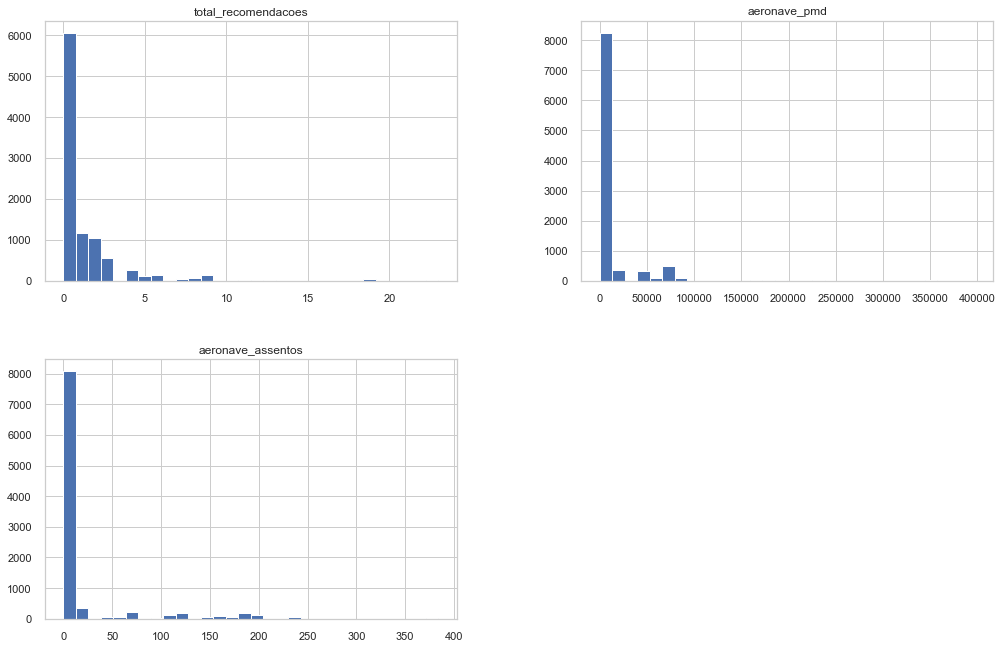

In [344]:
df_unificada_clean[['total_recomendacoes', 'aeronave_pmd', 'aeronave_assentos']].hist(bins=30, figsize=(17,11));

Verificando os histogramas, as variáveis ``total_recomendacoes``, ``total_aeronaves_envolvidas``,  ``aeronave_pmd``, ``aeronave_assentos`` possuem distribuição assimétrica à direita. 

Para mostrar dos outliers desse conjunto de dados, iremos analisar a distribuição estatística, plotar boxplots e calcular os limites utilizando a regra do IQR Score. Para isso, serão realizados os seguintes passos:

* Definir o Q1 e Q3 para as variáveis.
* Calcular o IQR para as variáveis.
* Definir o limite superior e inferior para os outliers.

O IQR é calculado subtraindo o Terceiro Quartil (75%) pelo Primeiro Quartil (25%).

**IQR = Q3 - Q1**

Vamos dar uma olhada nos dados e ver o que é identificado.

In [345]:
# definindo a função que mostra o resumo acerca dos outliers
def mostra_resumo_outliers(df_coluna):
  fig, ax = plt.subplots(figsize=(12, 3))
  sns.boxplot(df_coluna)
  plt.show()
  q1 = df_coluna.quantile(.25)
  q3 = df_coluna.quantile(.75)
  iqr = q3 - q1
  print("IQR da variável {}".format(df_coluna.name), iqr)
  superior = q3 + 1.5*(iqr)
  inferior = q1 - 1.5*(iqr)
  print("Limite superior da {}".format(df_coluna.name), superior)
  print("Limite inferior da {}".format(df_coluna.name), inferior)
  print('Quantidade de elementos acima do outlier:',len(df_coluna > superior))
  print('Quantidade de elementos abaixo do outlier:',len(df_coluna < inferior))

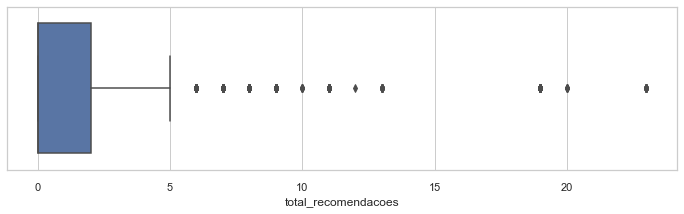

IQR da variável total_recomendacoes 2.0
Limite superior da total_recomendacoes 5.0
Limite inferior da total_recomendacoes -3.0
Quantidade de elementos acima do outlier: 9712
Quantidade de elementos abaixo do outlier: 9712


In [346]:
# mostrando resumo para "total_recomendacoes"
mostra_resumo_outliers(df_unificada_clean['total_recomendacoes'])

A variável ``total_recomendacoes`` possui 504 elementos acima dos valores de outlier.

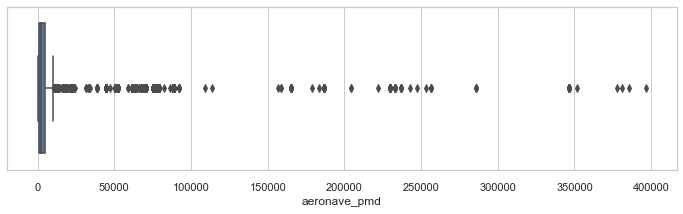

IQR da variável aeronave_pmd 3543.75
Limite superior da aeronave_pmd 10038.375
Limite inferior da aeronave_pmd -4136.625
Quantidade de elementos acima do outlier: 9712
Quantidade de elementos abaixo do outlier: 9712


In [347]:
# mostrando resumo para "total_recomendacoes"
mostra_resumo_outliers(df_unificada_clean['aeronave_pmd'])

A variável ``aeronave_pmd`` possui 1631 elementos acima dos valores de outlier.

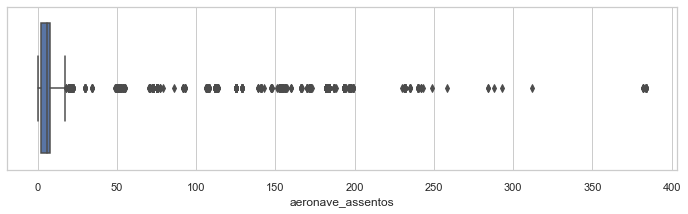

IQR da variável aeronave_assentos 6.0
Limite superior da aeronave_assentos 17.0
Limite inferior da aeronave_assentos -7.0
Quantidade de elementos acima do outlier: 9712
Quantidade de elementos abaixo do outlier: 9712


In [348]:
# mostrando resumo para "aeronave_assentos"
mostra_resumo_outliers(df_unificada_clean['aeronave_assentos'])

A variável ``aeronave_assentos`` possui 1440 elementos acima dos valores de outlier.

Por fim a variável alvo será alterada para:


*   1 se a linha tiver pelo menos uma vítima fatal,
*   0, caso contrário.



In [349]:
# primeiramente vamos alterar a varável alvo para 0 ou 1, onde 1 será atribuída a linha que tiver pelo menos uma vítima de acidente e 0, caso contrário
df_unificada_clean['tem_fatalidade'] = df_unificada_clean['aeronave_fatalidades_total'].apply(lambda x: 1 if x >= 1 else 0)
df_unificada_clean['tem_fatalidade'] = df_unificada_clean['tem_fatalidade'].astype(str)
df_unificada_clean.drop(columns=['aeronave_fatalidades_total'], inplace=True)

In [350]:
df_unificada_clean.tem_fatalidade.value_counts()

0    8246
1    1466
Name: tem_fatalidade, dtype: int64

**Os modelos de aprendizado de máquina ultilizados em classificação baseados em árvores são tolerantes à presença de outliers e por isso serão mantidos no dataset.** 

#### 4.1.2 Variáveis qualitativas
Serão realizadas as análises das variáveis que mais se destacam para análise.

In [351]:
# mostra o ranking dos 10 (dez) primeiros valores para uma dada coluna categórica
def mostra_grafico_barras(df_coluna):
    sns.set_theme(style="whitegrid")
    fig = plt.figure(figsize=(15,3))
    plt.title('Gráfico de barras de {}'.format(df_coluna.name))
    df_series = df_coluna.value_counts().head(10)
    print(df_coluna.value_counts(normalize=True).head(10))
    if(df_coluna.dtype != object):
      sns.barplot(x=df_series.index,y=df_series.values)
    else:
      sns.barplot(x=df_series.values,y=df_series.index)
    plt.xticks(rotation=90)
    plt.show()

In [352]:
type(df_unificada_clean['ocorrencia_classificacao'])

pandas.core.series.Series

0       0.041701
2010    0.040259
2008    0.037376
2012    0.036038
2009    0.034699
2011    0.032846
1980    0.030993
2007    0.029448
1992    0.029242
1979    0.027389
Name: aeronave_ano_fabricacao, dtype: float64


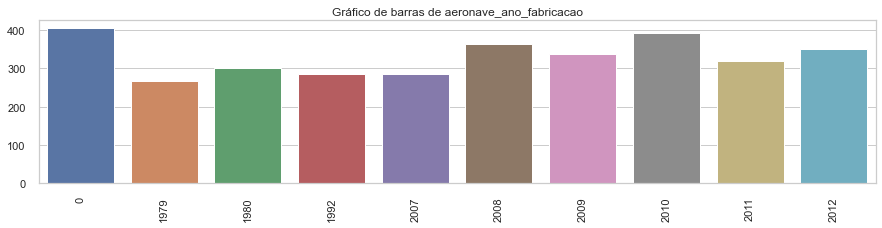

In [353]:
# mostrando as informações para o ano de fabricação
mostra_grafico_barras(df_unificada_clean['aeronave_ano_fabricacao'])

ACIDENTE           0.500927
INCIDENTE          0.345449
INCIDENTE GRAVE    0.153624
Name: ocorrencia_classificacao, dtype: float64


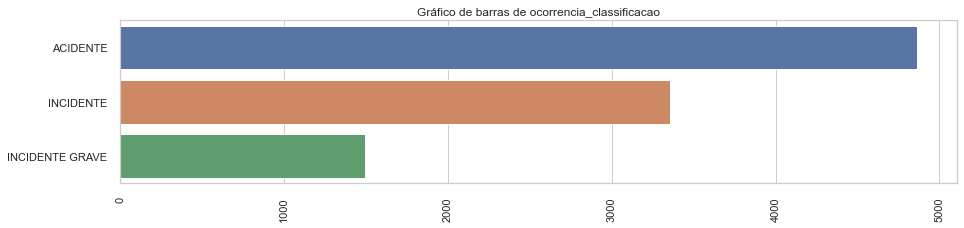

In [354]:
# mostrando as informações para classificação da ocorrência
mostra_grafico_barras(df_unificada_clean['ocorrencia_classificacao'])

Tem-se que quase metade das ocorrências se referem a um acidente.

RIO DE JANEIRO    0.048085
SÃO PAULO         0.040877
BRASÍLIA          0.023991
BELO HORIZONTE    0.022549
GOIÂNIA           0.022035
MANAUS            0.019666
GUARULHOS         0.018431
LONDRINA          0.017916
CAMPINAS          0.017298
RECIFE            0.017298
Name: ocorrencia_cidade, dtype: float64


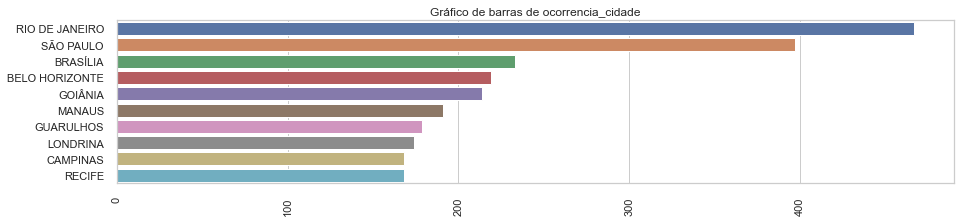

In [355]:
# mostrando as informações para cidade de ocorrência
mostra_grafico_barras(df_unificada_clean['ocorrencia_cidade'])

A maioria dos acidentes está concentrada nos principais centros urbanos do Brasil mas com destaque para a cidade de Londrina, responsável por 1,7% dos acidentes ou incidentes no país.

SP    0.214168
PR    0.082578
RJ    0.075680
RS    0.074238
MG    0.073517
PA    0.058587
GO    0.056528
MT    0.056116
BA    0.046643
AM    0.046129
Name: ocorrencia_uf, dtype: float64


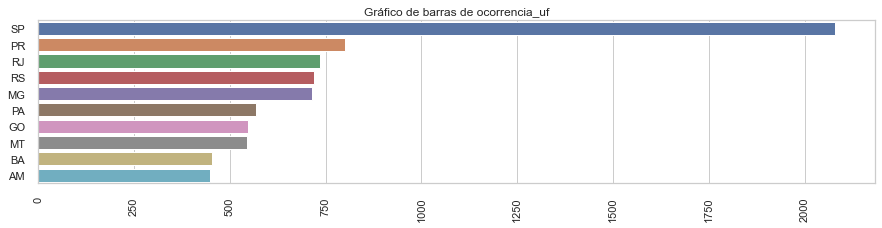

In [356]:
# mostrando as informações para o estado da ocorrência
mostra_grafico_barras(df_unificada_clean['ocorrencia_uf'])

Como esperado, o estado de São Paulo se destaca no número de ocorrências. Destaca-se em 2º lugar o estado do Paraná.

FALHA DO MOTOR EM VOO                                 0.112335
PERDA DE CONTROLE NO SOLO                             0.104716
PERDA DE CONTROLE EM VOO                              0.101730
FALHA OU MAU FUNCIONAMENTO DE SISTEMA / COMPONENTE    0.078666
ESTOURO DE PNEU                                       0.066413
COLISÃO COM OBSTÁCULO DURANTE A DECOLAGEM E POUSO     0.049012
COM TREM DE POUSO                                     0.045820
OUTROS                                                0.043657
EXCURSÃO DE PISTA                                     0.042422
COLISÃO COM AVE                                       0.030993
Name: ocorrencia_tipo, dtype: float64


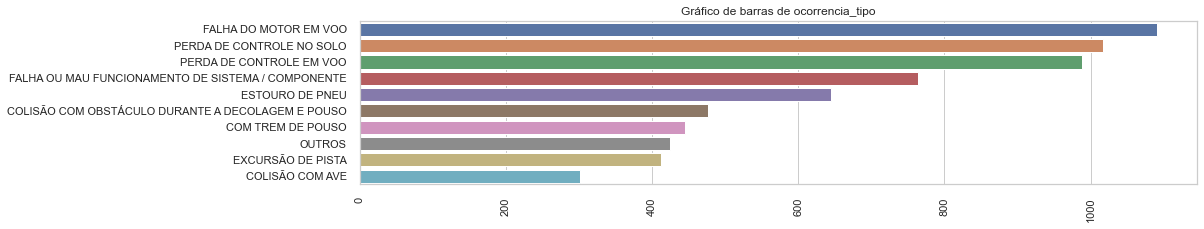

In [357]:
# mostrando as informações para o tipo de ocorrência
mostra_grafico_barras(df_unificada_clean['ocorrencia_tipo'])

A maioria dos acidentes ou incidentes são desencadeados pro alguma falha no motor.

AVIÃO           0.804469
HELICÓPTERO     0.139003
ULTRALEVE       0.038509
DESCONHECIDO    0.008958
PLANADOR        0.005457
ANFÍBIO         0.002780
TRIKE           0.000412
DIRIGÍVEL       0.000206
HIDROAVIÃO      0.000103
BALÃO           0.000103
Name: aeronave_tipo_veiculo, dtype: float64


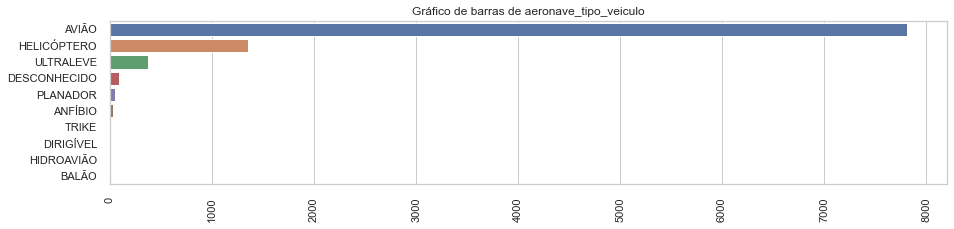

In [358]:
# mostrando as informações para o tipo de aeronave
mostra_grafico_barras(df_unificada_clean['aeronave_tipo_veiculo'])

Quase 80% das ocorrências envolve aviões.

AB-115             0.038303
EMB-810D           0.024815
EMB-201A           0.024815
EMB-202            0.024403
EMB-810C           0.023064
ATR-72-212A        0.022343
ERJ 190-200 IGW    0.019975
AS 350 B2          0.019666
152                0.018843
EMB-202A           0.017607
Name: aeronave_modelo, dtype: float64


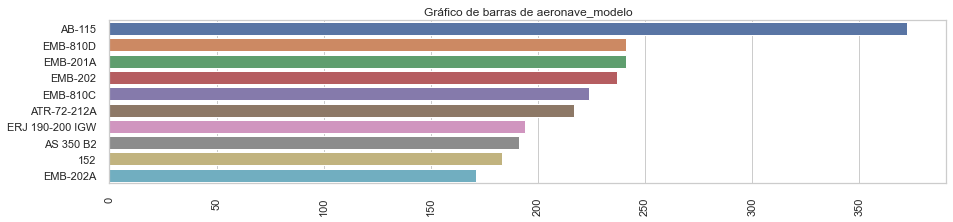

In [359]:
# mostrando as informações para o modelo de aeronave
mostra_grafico_barras(df_unificada_clean['aeronave_modelo'])

A maioria das ocorrências foram com o modelo AB-115. "Aero Boero AB-115 é um avião de treinamento de fabricação argentina. Com capacidade para dois pilotos, é amplamente utilizado nos aeroclubes e escolas de pilotagem do Brasil". (Wikipedia)

FORA DE AERODROMO                  0.396932
DESCONHECIDA                       0.020696
CAMPO DE MARTE                     0.017607
PRESIDENTE JUSCELINO KUBITSCHEK    0.014930
SANTOS DUMONT                      0.012768
GOVERNADOR ANDRÉ FRANCO MONTORO    0.012356
CONGONHAS                          0.010811
GUARARAPES - GILBERTO FREYRE       0.010194
AEROPORTO ESTADUAL DE JUNDIAÍ      0.009782
DEPUTADO LUÍS EDUARDO MAGALHÃES    0.009782
Name: aeronave_voo_origem, dtype: float64


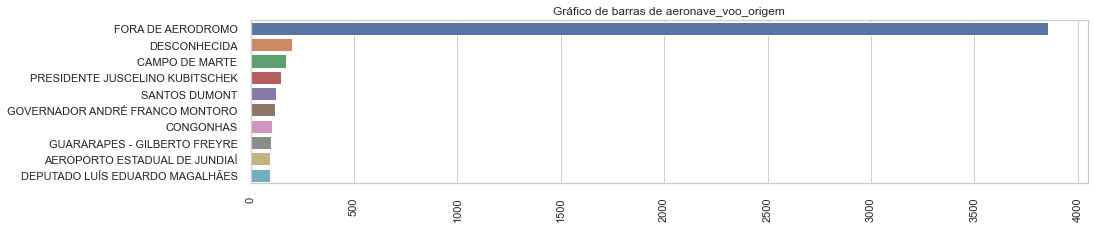

In [360]:
# mostrando as informações para o voo de origem
mostra_grafico_barras(df_unificada_clean['aeronave_voo_origem'])

Quase 40% das ocorrências foram fora do aerodromo. Em destaque temos que o aeródromo Campo de Marte é o que mais se destaca em ocorrências. O Aeroporto Campo de Marte é um aeroporto brasileiro, localizado na zona norte da cidade de São Paulo.

FORA DE AERODROMO                  0.427924
DESCONHECIDO                       0.017813
CAMPO DE MARTE                     0.015651
PRESIDENTE JUSCELINO KUBITSCHEK    0.009885
CONGONHAS                          0.009885
GOVERNADOR ANDRÉ FRANCO MONTORO    0.009164
GUARARAPES - GILBERTO FREYRE       0.008340
ANTONIO CARLOS JOBIM / GALEÃO      0.008134
GOVERNADOR JOSÉ RICHA              0.007619
BACACHERI                          0.007516
Name: aeronave_voo_destino, dtype: float64


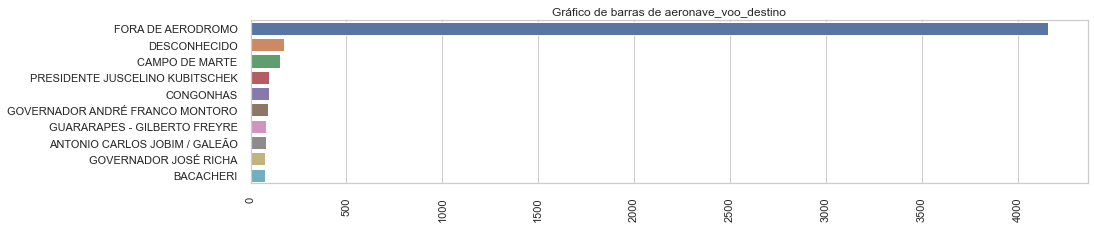

In [361]:
# mostrando as informações para o voo de destino
mostra_grafico_barras(df_unificada_clean['aeronave_voo_destino'])

Assim como os voos de origem, a maioria das ocorrências se deram fora do aeródromo.

MONOMOTOR      0.571046
BIMOTOR        0.396726
SEM TRAÇÃO     0.020593
TRIMOTOR       0.008237
***            0.002265
QUADRIMOTOR    0.001133
Name: aeronave_motor_quantidade, dtype: float64


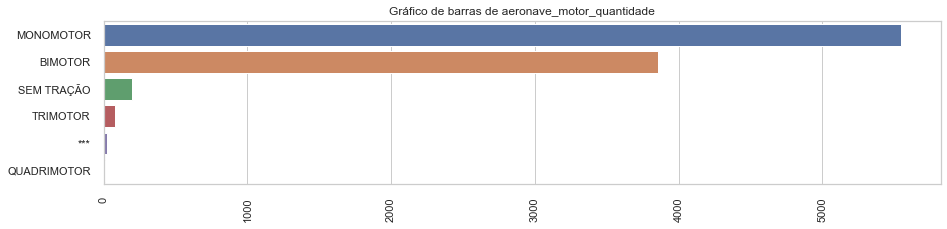

In [362]:
# mostrando as informações para a quantidade de motores na aeronave
mostra_grafico_barras(df_unificada_clean['aeronave_motor_quantidade'])

Cerca de 56% das ocorrências envolves aeronaves monomotores.

DECOLAGEM             0.176586
POUSO                 0.174732
CRUZEIRO              0.136738
CORRIDA APÓS POUSO    0.106363
SUBIDA                0.064559
TÁXI                  0.054057
APROXIMAÇÃO FINAL     0.050247
MANOBRA               0.044996
ESPECIALIZADA         0.032640
DESCIDA               0.030581
Name: aeronave_fase_operacao, dtype: float64


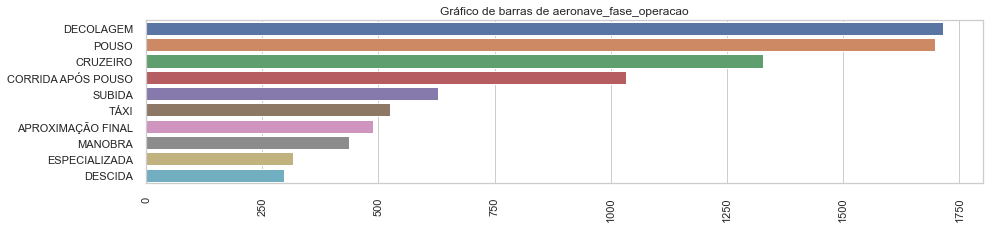

In [363]:
# mostrando as informações para a fase da operação quando da ocorrência
mostra_grafico_barras(df_unificada_clean['aeronave_fase_operacao'])

Verifica-se que mais de 35% das ocorrências são na decolagem ou pouso da aeronave.

JULGAMENTO DE PILOTAGEM        0.574341
APLICAÇÃO DE COMANDOS          0.046334
SUPERVISÃO GERENCIAL           0.038303
PLANEJAMENTO DE VOO            0.034905
MANUTENÇÃO DA AERONAVE         0.028933
PROCESSO DECISÓRIO             0.023270
ATITUDE                        0.021211
POUCA EXPERIÊNCIA DO PILOTO    0.019872
INDISCIPLINA DE VOO            0.016783
PERCEPÇÃO                      0.016166
Name: fator_nome, dtype: float64


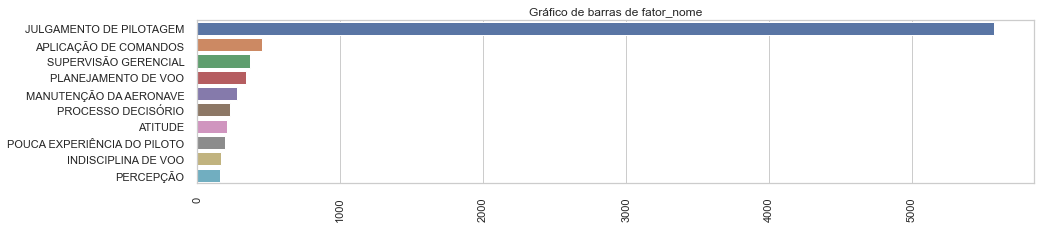

In [364]:
# mostrando as informações para o fator da ocorrência
mostra_grafico_barras(df_unificada_clean['fator_nome'])

Mais de 61% das ocorrências de acidentes ou incidentes envolvem fatores humanos no que diz respeito ao julgamento de pilotagem ou aplicação de comandos.

DESEMPENHO DO SER HUMANO                          0.806322
ASPECTO PSICOLÓGICO                               0.145696
ELEMENTOS RELACIONADOS AO AMBIENTE OPERACIONAL    0.013591
ASPECTO MÉDICO                                    0.009061
INFRAESTRUTURA AEROPORTUÁRIA                      0.008958
OUTRO                                             0.008031
***                                               0.002986
ERGONOMIA                                         0.001442
ASPECTO DE FABRICAÇÃO                             0.001339
ASPECTO DE PROJETO                                0.001133
Name: fator_aspecto, dtype: float64


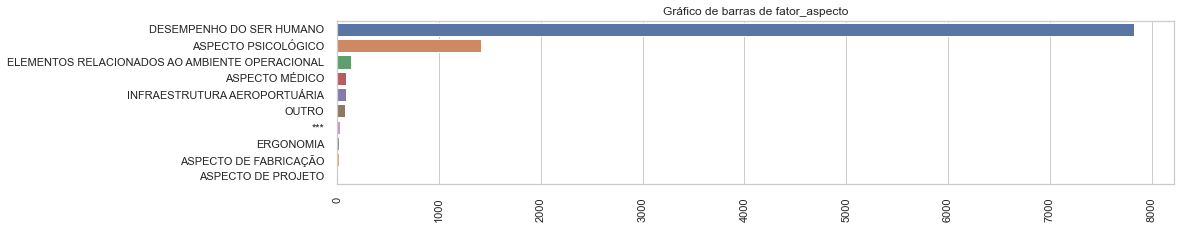

In [365]:
# mostrando as informações para o aspecto da ocorrência
mostra_grafico_barras(df_unificada_clean['fator_aspecto'])

Mais de 94% das ocorrências estão relacionadas aos aspectos humanos (falhas humanas).

OPERAÇÃO DA AERONAVE                      0.821561
INDIVIDUAL                                0.088035
ORGANIZACIONAL                            0.041186
MANUTENÇÃO DA AERONAVE                    0.028933
PSICOSSOCIAL                              0.016474
PRESTAÇÃO DE SERVIÇOS DE TRÁFEGO AÉREO    0.003810
Name: fator_condicionante, dtype: float64


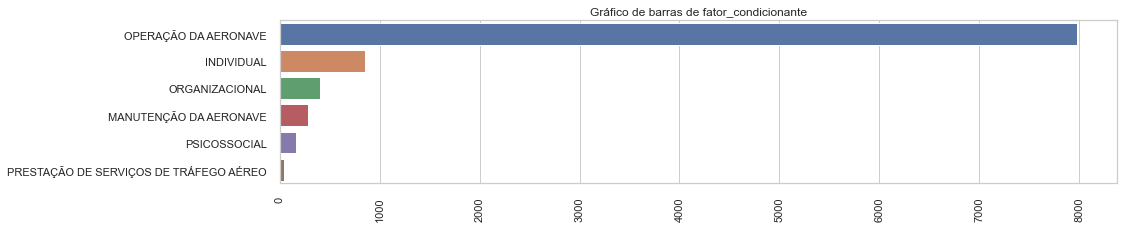

In [366]:
# mostrando as informações para o fator condicionante da ocorrência
mostra_grafico_barras(df_unificada_clean['fator_condicionante'])

O fator condicionante principal das ocorrências refere-se a operação da aeronave (82,4%).

1     0.091227
9     0.088653
7     0.086285
8     0.085461
10    0.084123
3     0.083505
12    0.083299
6     0.083299
4     0.081857
5     0.081240
Name: ocorrencia_mes, dtype: float64


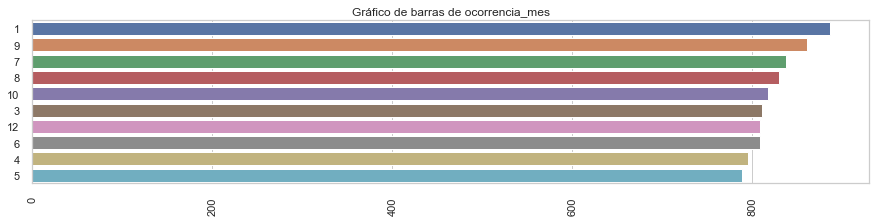

In [367]:
# motrando as informações sobre o mês da ocorrência
mostra_grafico_barras(df_unificada_clean['ocorrencia_mes'])

O mês de maior ocorrência de acidentes ou incidentes é Janeiro.

### 4.2 Análise Bivariada
#### 4.2.1 Análise Bivariada das Variáveis Quantitativas com a variável resposta

In [368]:
# definindo a função de análise
def analise_biv_quantitativa(df_coluna, df_alvo):
    plt.subplots(figsize=(5,5))
    plt.title('Analise Bivariada  de {}'.format(df_coluna.name))
    sns.boxplot(y=df_coluna, x=df_alvo)
    plt.tight_layout()   

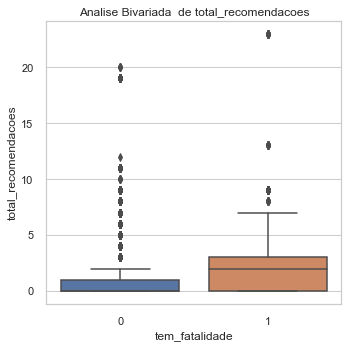

In [369]:
# analisando a variável total_recomendacoes com a variável alvo tem_fatalidade
analise_biv_quantitativa(df_unificada_clean['total_recomendacoes'], df_unificada_clean.tem_fatalidade)

Tem-se que grande parte das ocorrências possuem menos de 5 recomendações. Ressalta-se que quando há fatalidade(s) existem mais recomendações do que quando não há.

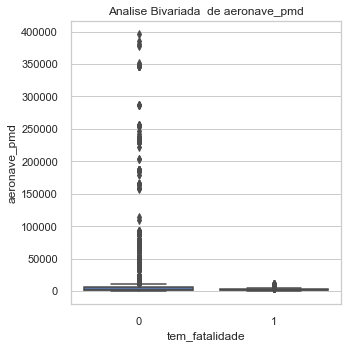

In [370]:
# analisando a variável aeronave_pmd com a variável alvo tem_fatalidade
analise_biv_quantitativa(df_unificada_clean['aeronave_pmd'], df_unificada_clean.tem_fatalidade)

Nota-se que todas as aeronaves envolvidas em ocorrências com fatalidades possuem baixo peso. Assim, aviões comerciais com pesos elevados tem menos chances de se envolverem em acidentes com vítimas fatais.

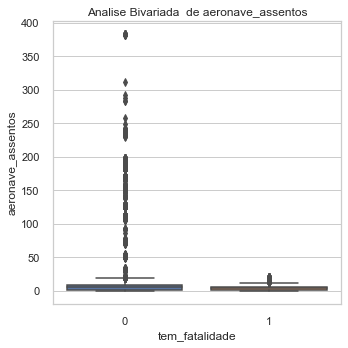

In [371]:
# analisando a variável aeronave_assentos com a variável alvo tem_fatalidade
analise_biv_quantitativa(df_unificada_clean['aeronave_assentos'], df_unificada_clean.tem_fatalidade)

Novamente temos que aviões de pequeno porte com menos de 30 assentos são os que mais se envolvem com acidentes tendo vítimas fatais. 

#### 4.2.2 Análise Bivariada das Variáveis Qualitativas com a variável resposta

In [372]:
# função para plotar as 10 elementos com os valores mais frequentes em relação a variável alvo
def analise_biv_qualitativa(df, df_coluna, alvo):
    dez_primeiros = df_coluna .value_counts().head(10)
    df_temp = df[df_coluna.isin(dez_primeiros.index)]
    fig = plt.figure(figsize=(18,5))
    plt.title('Analise Bivariada  de {}'.format(df_coluna.name))
    plt.xticks(rotation=90)
    sns.countplot(x=df_coluna.name, hue=alvo, data=df_temp)
    plt.show()
    

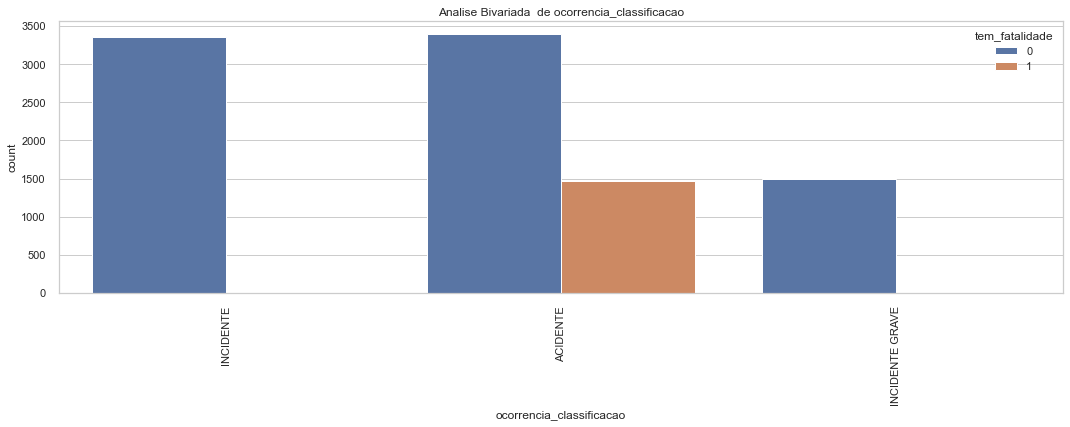

In [373]:
# mostrando a análise vivariada para classificação da ocorrência
analise_biv_qualitativa(df_unificada_clean, df_unificada_clean['ocorrencia_classificacao'], df_unificada_clean.tem_fatalidade.name)

Quando há vítima fatal, a ocorrência é classificada com acidente. Quase a metade dos acidentes possuem vítima fatal.

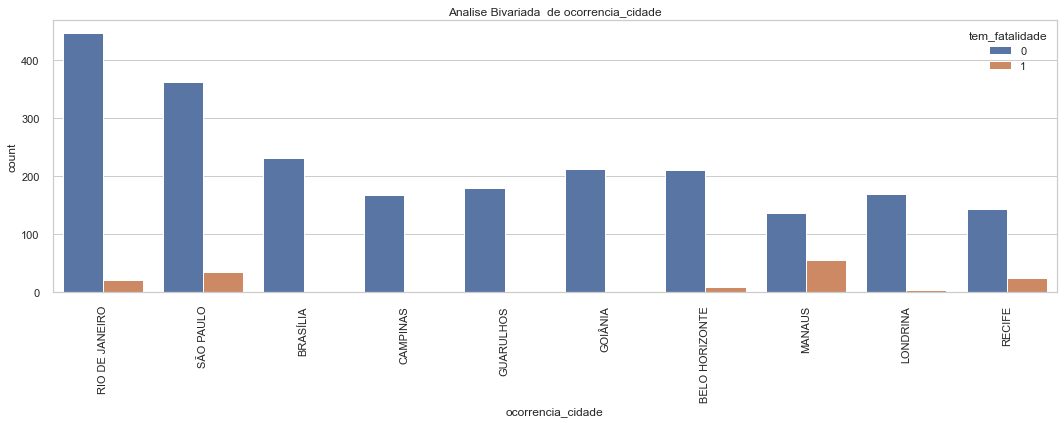

In [374]:
# mostrando a análise para cidade de ocorrência
analise_biv_qualitativa(df_unificada_clean, df_unificada_clean['ocorrencia_cidade'], df_unificada_clean.tem_fatalidade.name)

As cidades com mais acidentes são: Rio de Janeiro, São Paulo, Belo Horizonte, Manaus, Londrina e Recife.

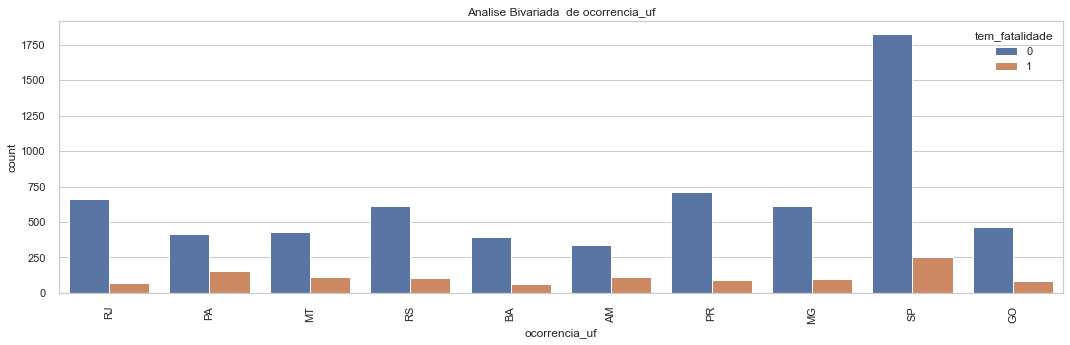

In [375]:
# mostrando a análise em relação ao estado
analise_biv_qualitativa(df_unificada_clean, df_unificada_clean['ocorrencia_uf'], df_unificada_clean.tem_fatalidade.name)

Mais uma vez o estado de São Paulo se destaca como o principal no número de ocorrências de acidentes e incidentes. Destaca-se também o estado do Pará que embora não tenha muitas ocorrências, possui grande número nos acidentes.

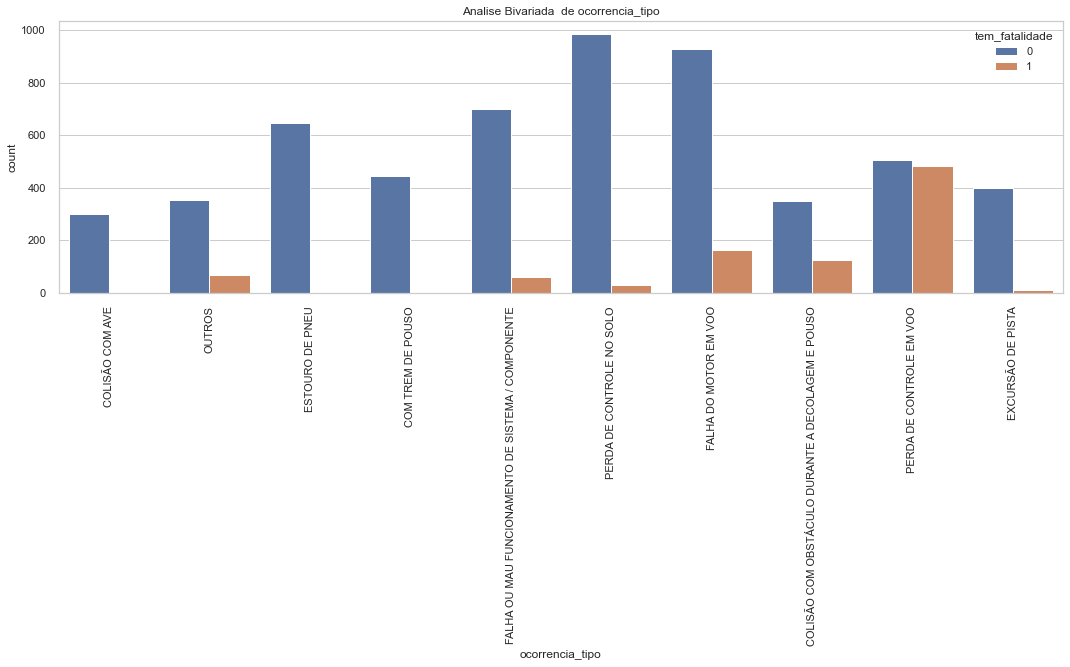

In [376]:
# mostrando a análise em relação ao tipo de ocorrência
analise_biv_qualitativa(df_unificada_clean, df_unificada_clean['ocorrencia_tipo'], df_unificada_clean.tem_fatalidade.name)

A perda do controle em voo é o principal tipo de ocorrência causadora de fatalidade aérea no país. Quase sempre, quando existe tal perda, haverá vítima fatal.

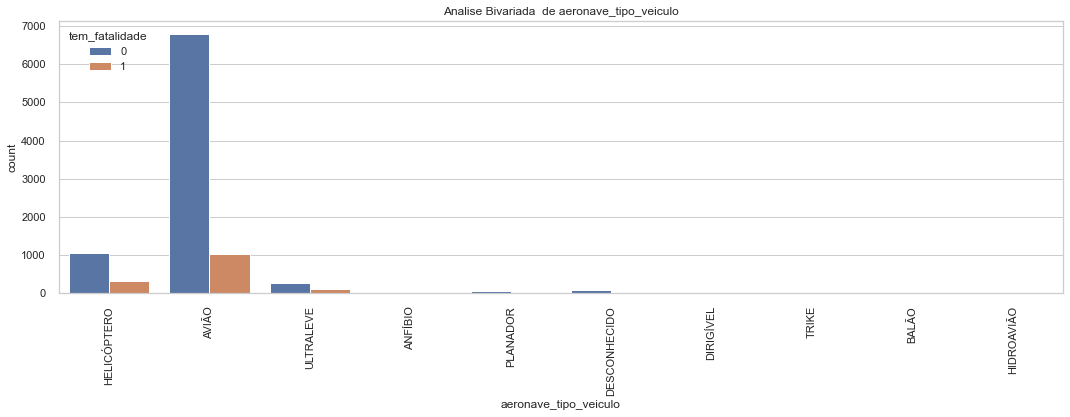

In [377]:
# mostrando a análise em relação ao tipo de veículo
analise_biv_qualitativa(df_unificada_clean, df_unificada_clean['aeronave_tipo_veiculo'], df_unificada_clean.tem_fatalidade.name)

Como o avião é o principal veículo de transporte aéreo, também é nesse meio que ocorrem a maior de acidentes com vítimas fatais.

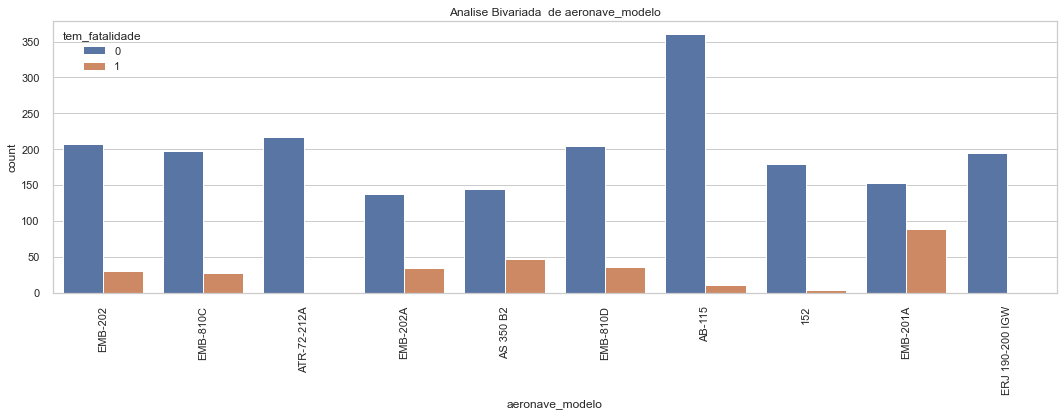

In [378]:
# mostrando a análise em relação ao modelo da aeronave
analise_biv_qualitativa(df_unificada_clean, df_unificada_clean['aeronave_modelo'], df_unificada_clean.tem_fatalidade.name)

O modelo EMB-201A da empresa EMBRAER é o principal modelo envolvido nos acidentes com vítima fatal. 

Idealizado para pulverizar plantações com fertilizantes e pesticidas, também pode ser utilizado para espalhar sementes, combater incêndios e criar chuva artificial. Para proteger o piloto do contato com os produtos químicos, a cabine do Ipanema conta com um sistema de vedação e a dispersão dos defensivos químicos ocorre na parte posterior das asas. Por voar em baixas altitudes, conta com um equipamento corta-fios. Ao longo dos anos diversas variantes do Ipanema foram certificadas e postas à disposição:

EMB 200 - Certificado em 1971. Primeira versão de produção com motor Lycoming de 260 HP. A capacidade do reservatório era de 550 kg.

EMB 200A - Certificado em 1973. Similar a anterior com alguns aperfeiçoamentos.

EMB 201 - Certificado em 1974. Motor Lycoming de 300 HP, alterações aerodinâmicas. A capacidade do reservatório era de 750 kg.

EMB 201A - Certificado em 1977. Similar a anterior com novo painel, controles e asas.

Fonte: Wikipedia (https://pt.wikipedia.org/wiki/Embraer_EMB-200)

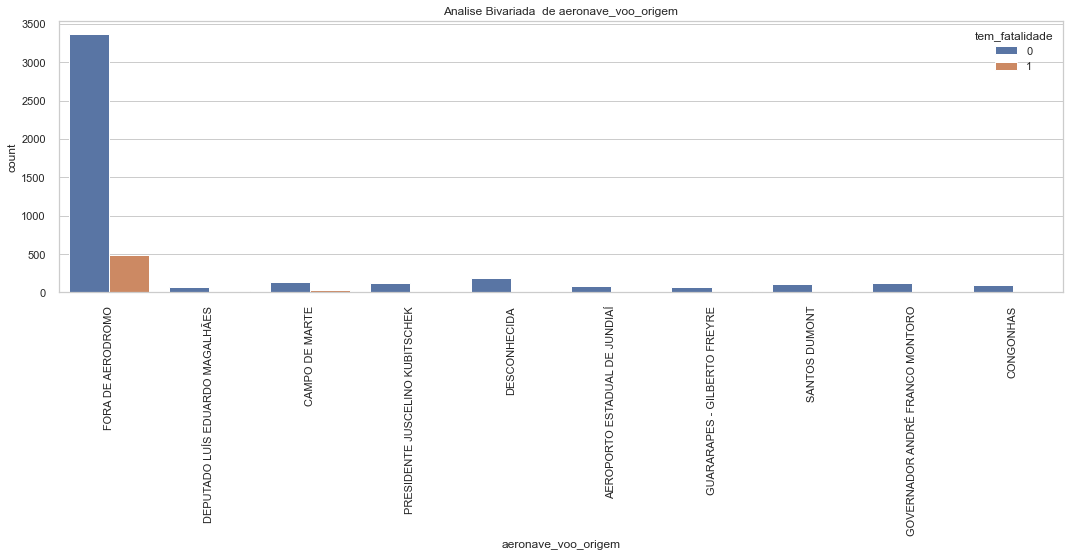

In [379]:
# mostrando a análise em relação à origem do voo
analise_biv_qualitativa(df_unificada_clean, df_unificada_clean['aeronave_voo_origem'], df_unificada_clean.tem_fatalidade.name)

Grande parte dos acidentes com vítimas fatais acontecem fora do aeródromo. Os aeródromos de origem do voo com vítimas que se destacam estão listados no gráfico.

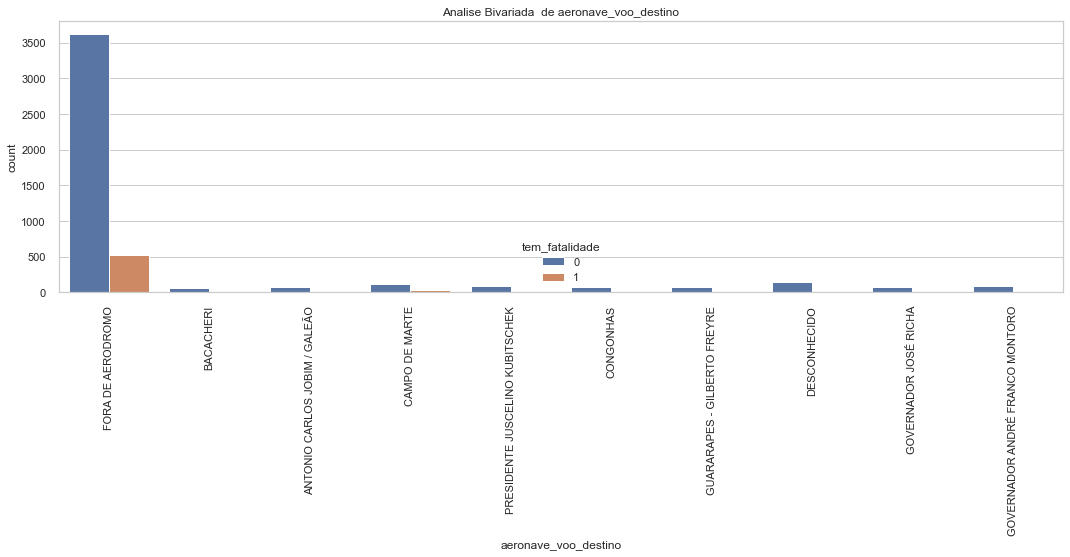

In [380]:
# mostrando a análise em relação ao destino do voo
analise_biv_qualitativa(df_unificada_clean, df_unificada_clean['aeronave_voo_destino'], df_unificada_clean.tem_fatalidade.name)

Grande parte dos acidentes com vítimas fatais acontecem fora do aeródromo. Os aeródromos de destino do voo com vítimas que se destacam estão listados no gráfico.

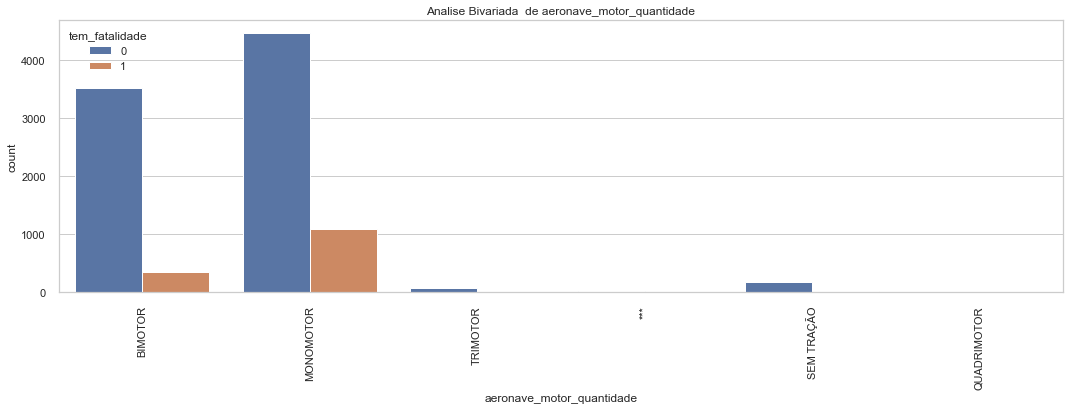

In [381]:
# mostrando a análise em relação à quantidade de motores
analise_biv_qualitativa(df_unificada_clean, df_unificada_clean['aeronave_motor_quantidade'], df_unificada_clean.tem_fatalidade.name)

A maioria dos acidentes com vítima fatal está relacionada às aeronaves monomotores, demonstrando que esse tipo é o mais arriscado para se voar.

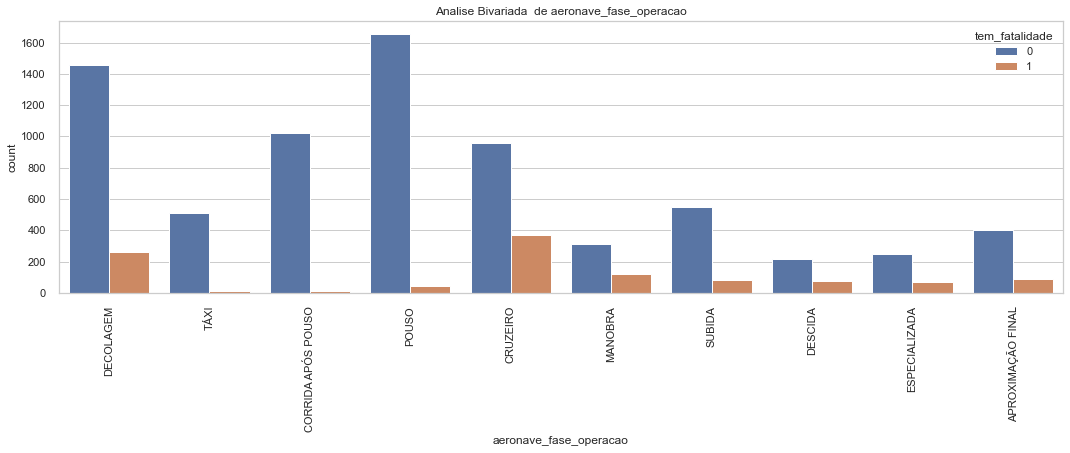

In [382]:
# mostrando a análise em relação à fase de operação 
analise_biv_qualitativa(df_unificada_clean, df_unificada_clean['aeronave_fase_operacao'], df_unificada_clean.tem_fatalidade.name)

A maior parte das fatalidades ocorrem durante o voo de cruzeiro, seguida da fase de decolagem. 

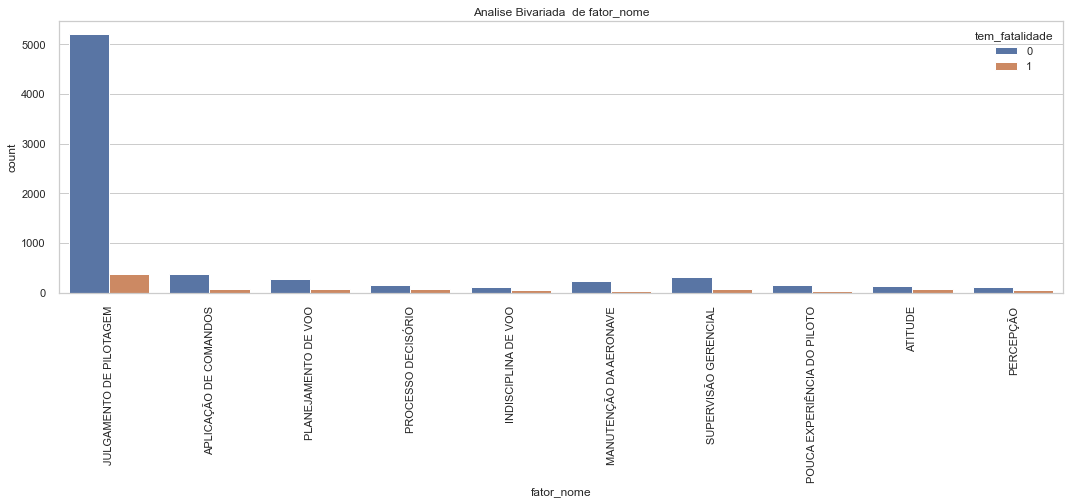

In [383]:
# mostrando a análise em relação ao fator da ocorrência
analise_biv_qualitativa(df_unificada_clean, df_unificada_clean['fator_nome'], df_unificada_clean.tem_fatalidade.name)

Grande parte das ocorrências estão relacionadas ao "julgamento de pilotagem", incluindo aquelas onde há vítimas fatais.

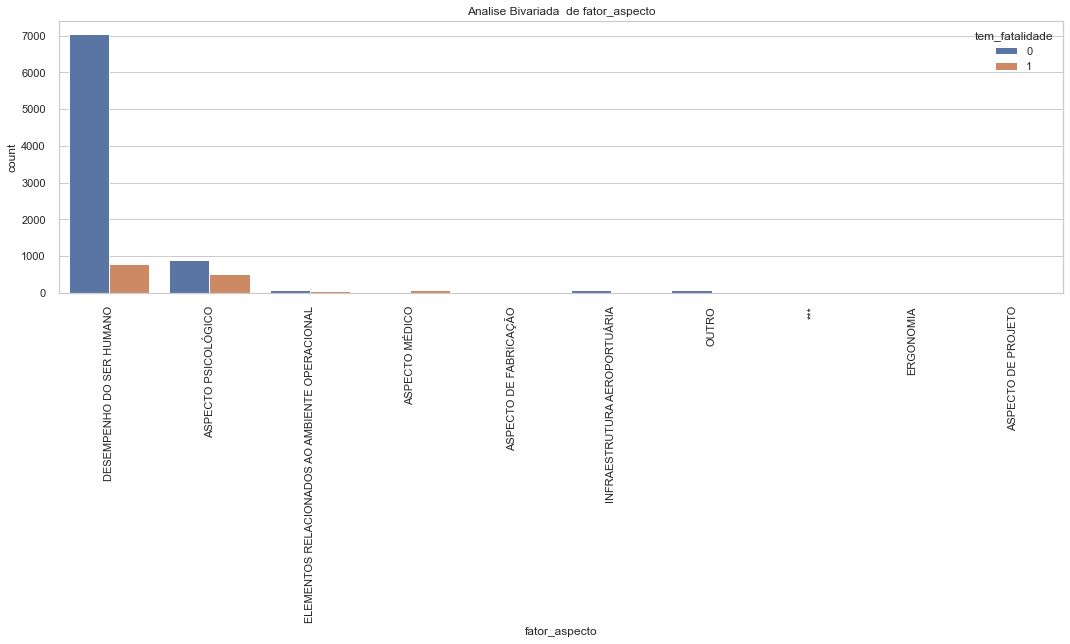

In [384]:
# mostrando a análise em relação ao aspecto da ocorrência
analise_biv_qualitativa(df_unificada_clean, df_unificada_clean['fator_aspecto'], df_unificada_clean.tem_fatalidade.name)

Os fatores humanos 'Desempenho do ser humano' e 'aspecto psicológico' são os aspectos mais importantes na causa dos acidentes com vítimas fatais.

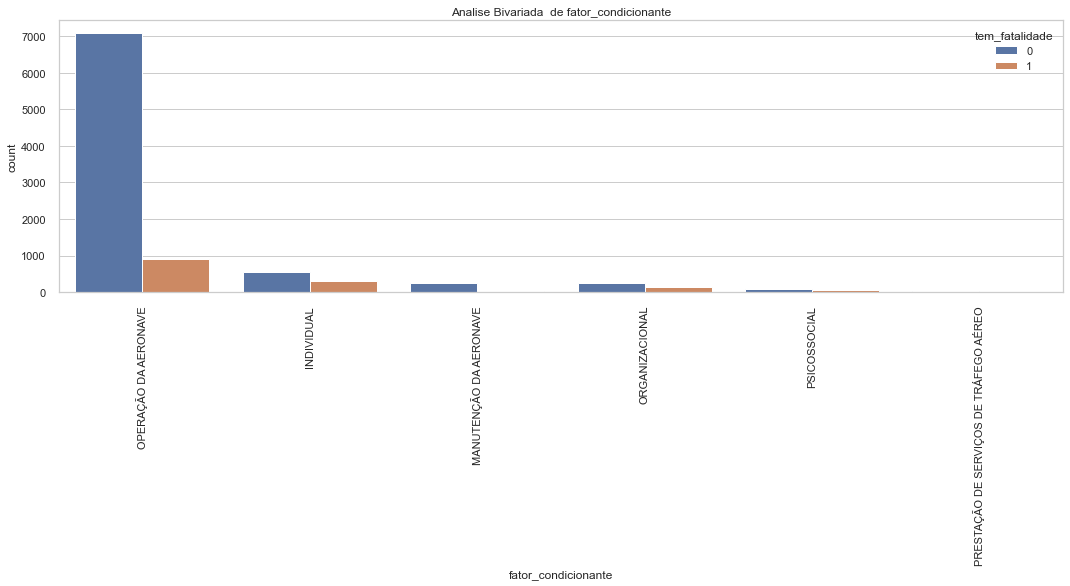

In [385]:
# mostrando a análise em relação ao fator condicionante da ocorrência
analise_biv_qualitativa(df_unificada_clean, df_unificada_clean['fator_condicionante'], df_unificada_clean.tem_fatalidade.name)

A operação da aeronave se destaca como o principal fator condicionante para os acidentes com vítima fatal.

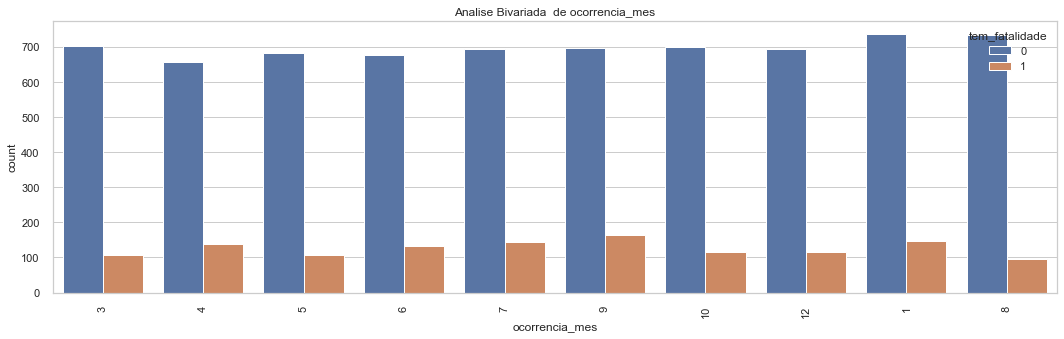

In [386]:
# mostrando a análise em relação ao mês da ocorrência
analise_biv_qualitativa(df_unificada_clean, df_unificada_clean['ocorrencia_mes'], df_unificada_clean.tem_fatalidade.name)

Todas as ocorrências com vítima ou não estão distribuídas quase que uniformemente ao longo do ano.

In [387]:
# apenas redefinindo o tipo da variável alvo
df_unificada_clean['tem_fatalidade'] = df_unificada_clean['tem_fatalidade'].astype(int)

## 4.3 Matriz de correlação

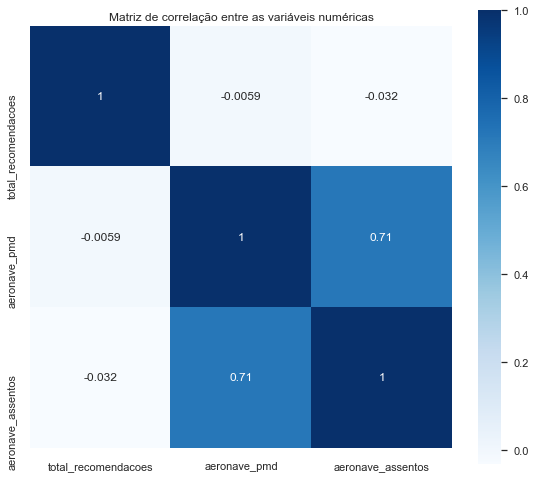

In [388]:
# mostrando a matriz de correlação
corr = df_unificada_clean[['total_recomendacoes', 'aeronave_pmd', 'aeronave_assentos']].corr()
plt.figure(figsize=(8,7))
plt.title('Matriz de correlação entre as variáveis numéricas')
sns.heatmap(corr, cmap='Blues', square=True, annot=True)
plt.tight_layout()

Na matriz acima, percebe-se que existe uma forte correlação de 0,71 entre as variáveis ``aeronave_assentos`` e ``aeronave_pmd``, isso porque as aeronaves com maior número de assentos possuem também uma capacidade maior no peso suportado.

# 5 - Criação de Modelos de Machine Learning

Para escolha do melhor modelo, será utlizidada a biblioteca ``Pycaret``. 

<p align="center"><img src="https://github.com/guilherme-beserra/TCC---PUC-Minas/blob/main/imagens/pycaret.png?raw=true" width="30%"></p>

Pycaret é uma biblioteca aberta (``opensource``), de baixa codificação (``low-code``) para ``machine learning``, demandando poucas linhas de código e que automatiza seu fluxo fim-a-fim. Ela acelera exponencialmente o ciclo experimental de todo o processo para o Cientista de Dados, reduzindo o tempo de ciclo entre uma hipótese e insights em experimentos com ``machine learning``.    

Ao englobar diversas bibliotecas e frameworks de ``machine learning`` (scikit-learn, XGBoost, Microsoft LightGBM, spaCy etc.), o Pycaret permite que o cientista de dados crie e otimize vários modelos de ML ao mesmo tempo, de forma organizada e simples de entender.

### 5.1 - Importando as bibliotecas necessárias

In [389]:
# importando as funcionalidades utilizadas
from pycaret.classification import *

In [390]:
from pycaret.utils import version
version()

'2.3.6'

### 5.2 - Obtendo os dados de treino e validação
Neste ponto, os dados não vistos (`unseen`) serão retirados do dataset original em 5% para teste("validação") dos modelos quando estes estiverem finalizados. 

In [391]:
# separando os dados em treino e validação
dados_treino = df_unificada_clean.sample(frac=0.95, random_state=1012)
dados_validacao = df_unificada_clean.drop(dados_treino.index)
dados_treino.reset_index(inplace=True, drop=True)
dados_validacao.reset_index(inplace=True, drop=True)
print('Dados de treino e teste para modelagem: ' + str(dados_treino.shape))
print('Dados de validação para predição: ' + str(dados_validacao.shape))

Dados de treino e teste para modelagem: (9226, 38)
Dados de validação para predição: (486, 38)


### 5.3 - Configuração (``setup``) do Pycaret
A função de ``setup`` inicializa o ambiente no pycaret e cria um ``pipeline`` para preparar os dados para modelagem. 

Internamente e por padrão, esta função também irá separar também os dados em treino e teste. A proporção da divisão será de 30(treino)/70(teste).

**Nesta etapa, não há necessidade de aplicar o ``enconding`` para as variáveis categóricas e binárias haja visto que o ``pycaret`` realizará esta tarefa atrés do parâmetro ``normalize``.**

Sobre os demais parâmetros:

*   ``data`` - todo ``dataset`` a ser analisado (parâmetro obrigatório).
*   ``session_id`` - número pseudo-randômico, distribuído como semente para todas as funções para reprodutibilidade. 
*   ``target`` - variável alvo (parâmetro obrigatório).
*   ``transformation`` - transforma os dados que fiquem mais próximos de uma distribuição normal.
*   ``ignore_low_variance`` - todas as variáveis categóricas com variâncias insignificantes são removidas. A variância é calculada usando a taxa de valores únicos para o número de amostras, e a taxa dos valores mais comuns para frequência do segundo valor mais comum.
*   ``pca`` - A Análise de Componentes Principais (PCA) é uma técnica não supervisionada usada em aprendizado de máquina para reduzir a dimensionalidade dos dados. Ela faz isso comprimindo o espaço de atributos, identificando um subespaço que captura a maioria das informações na matriz completa de atributos.
*   ``log_experiment`` - todas as métricas e parâmetros são armazenados em log.




In [392]:
# criando o pipeline
clf = setup(data = df_unificada_clean,
            session_id = 1234,
            target = 'tem_fatalidade',
            normalize = True,
            transformation = True, 
            ignore_low_variance = True,
            pca = True,
            log_experiment = True)

,Description,Value
0,session_id,1234
1,Target,tem_fatalidade
2,Target Type,Binary
3,Label Encoded,None
4,Original Data,"(9712, 38)"
5,Missing Values,False
6,Numeric Features,5
7,Categorical Features,31
8,Ordinal Features,False
9,High Cardinality Features,False


Após execução, são apresentadas informações ao ``pipeline`` de pré-processamento conforme os parâmetros estabelecidos. Dentre as informações, destacamos:

*  ``Target Type`` - tipo de alvo automaticamente detectado; neste caso: binário.
*   ``Label Encoded`` - Neste caso, não foi necessário o ``encoding`` da variável algo para 0 ou 1, tendo em vista que ela já se encontrava nesse formato.
*   ``Original Data`` - Mostra a dimensão do ``dataset`` original.
*   ``Missing Values`` - mostra que não há valores faltantes.
*   ``Transformed Train Set`` - mostra a dimensão do conjunto de treino (30%):(2914, 1085).
*   ``Transformed Test Set`` - mostra a dimensão do conjunto de teste (70%): (6798, 1085).

Percebe-se que com a transformação dos dados categóricos, a quantidade de variáveis passou a ser 1085.


### 5.4 - Comparando os modelos
Nesta etapa, será utilizado o método ``compare_models()`` que irá comparar e apresentar os melhores modelos ordenados (em ordem decrescente) pela "Acurácia". Todos os modelos são avaliados usando-se ``cross-validation`` através do particionamento dos dados de treinamento em 10 (``folds``) e o resultado final para cada modelo será obtido pela média dos resultados parciais.

Como os dados não estão balanceados, será utilizada a acurácia balanceada.

In [393]:
# adicionando a métrica de acurácia balanceada
add_metric('balanced_accuracy', 'BalancedAccuracy', balanced_accuracy_score, greater_is_better = True)
remove_metric('Accuracy')
remove_metric('Kappa')
remove_metric('MCC')

In [179]:
# comparando e apresentando os melhores modelos
melhor_modelo = compare_models(sort='BalancedAccuracy')

,Model,AUC,Recall,Prec.,F1,BalancedAccuracy,TT (Sec)
svm,SVM - Linear Kernel,0.0000,0.8858,0.9003,0.8925,0.9340,0.2210
lda,Linear Discriminant Analysis,0.9810,0.8907,0.8746,0.8823,0.9338,1.3100
ridge,Ridge Classifier,0.0000,0.8830,0.9001,0.8912,0.9326,0.1830
lr,Logistic Regression,0.9872,0.8684,0.9027,0.8846,0.9257,3.5550
lightgbm,Light Gradient Boosting Machine,0.9917,0.8558,0.9571,0.9032,0.9244,7.1340
xgboost,Extreme Gradient Boosting,0.9902,0.8520,0.9557,0.9007,0.9224,24.9970
catboost,CatBoost Classifier,0.9899,0.8432,0.9588,0.8965,0.9183,146.4310
knn,K Neighbors Classifier,0.9701,0.8279,0.9089,0.8663,0.9065,4.0090
et,Extra Trees Classifier,0.9804,0.6866,1.0000,0.8136,0.8433,1.0030
gbc,Gradient Boosting Classifier,0.9781,0.6943,0.9232,0.7912,0.8419,45.4760


In [180]:
# mostrando o melhor modelo
melhor_modelo

SGDClassifier(alpha=0.0001, average=False, class_weight=None,
              early_stopping=False, epsilon=0.1, eta0=0.001, fit_intercept=True,
              l1_ratio=0.15, learning_rate='optimal', loss='hinge',
              max_iter=1000, n_iter_no_change=5, n_jobs=-1, penalty='l2',
              power_t=0.5, random_state=1234, shuffle=True, tol=0.001,
              validation_fraction=0.1, verbose=0, warm_start=False)

Dentre os 15 (quinze) modelos avaliados, destacamos que: 	

* Os modelos: `SGDClassifier (SVM)`, `Linear Discriminant Analysis` e `	Ridge Classifier` foram os que apresentaram melhores resultados em relação a acurácia balanceada e serão utilizados para uma análise mais detalhada. Nota-se que os resultados dos 3 (três) modelos em relação a acurácia balanceada e Recall ficaram muito próximos. 
* O modelo `Ridge Classifier` foi o mais rápido dentre os três primeiros.
* O modelo `	Linear Discriminant Analysis` apresentou melhor Recall.
* O modelo `Extra Trees Classifier`apresentou melhor precisão, mas um Recall e acurácia balanceada abaixo dos 3 (três) melhores.


### 5.5 - Criando e otimizando os modelos
Apesar do `compare_models()` ser uma função poderosa e ponto de partida, ela não retorna modelos treinados. O *workflow* recomendado pelo PyCaret é usar o compare_models logo após o setup para avaliar os modelos que performam melhor com o conjunto de dados e selecionar os candidatos para seguir na análise.

Dessa forma, a função permite que você crie modelos a partir da função `create_model()`. 

Por padrão, o PyCaret já faz a divisão dentro do conjunto de treino em conjuntos de validação, para trabalhar com 10 folds de validação. Essa função cria o modelo e o avalia usando uma *stratified cross validation*.

#### 5.5.1 - Criando os modelos

In [181]:
# instanciando o primeiro modelo
svm = create_model('svm')

,AUC,Recall,Prec.,F1,BalancedAccuracy
0,0.0000,0.8932,0.9200,0.9064,0.9397
1,0.0000,0.8932,0.9485,0.9200,0.9423
2,0.0000,0.9029,0.9029,0.9029,0.9428
3,0.0000,0.8447,0.8529,0.8488,0.9093
4,0.0000,0.8942,0.8942,0.8942,0.9376
5,0.0000,0.8750,0.9381,0.9055,0.9323
6,0.0000,0.9231,0.8649,0.8930,0.9485
7,0.0000,0.9038,0.9307,0.9171,0.9458
8,0.0000,0.8835,0.8349,0.8585,0.9261
9,0.0000,0.8447,0.9158,0.8788,0.9154


In [182]:
# verificando os parâmetros
print(svm)

SGDClassifier(alpha=0.0001, average=False, class_weight=None,
              early_stopping=False, epsilon=0.1, eta0=0.001, fit_intercept=True,
              l1_ratio=0.15, learning_rate='optimal', loss='hinge',
              max_iter=1000, n_iter_no_change=5, n_jobs=-1, penalty='l2',
              power_t=0.5, random_state=1234, shuffle=True, tol=0.001,
              validation_fraction=0.1, verbose=0, warm_start=False)


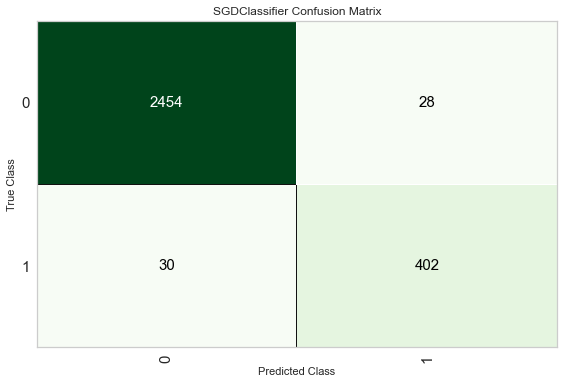

In [183]:
# plotando matriz de confusão
plot_model(svm, plot='confusion_matrix')

Tem-se uma acurácia balanceada de 95,96% aproximadamente para o `SGDClassifier(SVM)`.

In [184]:
# instanciando o segundo modelo
lda = create_model('lda')

,AUC,Recall,Prec.,F1,BalancedAccuracy
0,0.9888,0.9029,0.8692,0.8857,0.9393
1,0.9855,0.8544,0.9263,0.8889,0.9211
2,0.9809,0.8932,0.8440,0.8679,0.9319
3,0.9852,0.9029,0.8611,0.8815,0.9385
4,0.9781,0.9135,0.8879,0.9005,0.9463
5,0.9810,0.8942,0.9029,0.8986,0.9384
6,0.9818,0.8942,0.8692,0.8815,0.9350
7,0.9879,0.9038,0.8952,0.8995,0.9424
8,0.9655,0.8835,0.8349,0.8585,0.9261
9,0.9756,0.8641,0.8558,0.8599,0.9190


In [185]:
# verificando os parâmetros
print(lda)

LinearDiscriminantAnalysis(n_components=None, priors=None, shrinkage=None,
                           solver='svd', store_covariance=False, tol=0.0001)


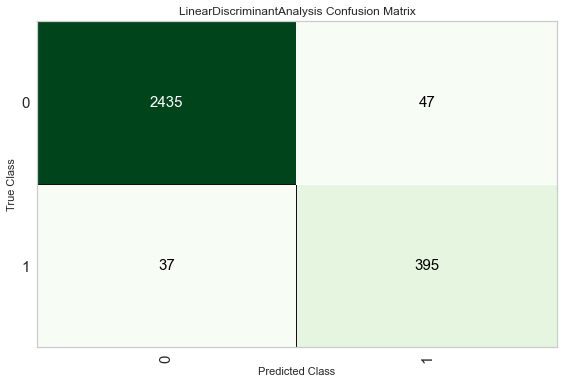

In [186]:
# plotando matriz de confusão
plot_model(lda, plot='confusion_matrix')

Tem-se uma acurácia balanceada de 94,75% aproximadamente para o `Linear Discriminant Analysis`.	

In [187]:
# instanciando o terceiro modelo
ridge = create_model('ridge')

,AUC,Recall,Prec.,F1,BalancedAccuracy
0,0.0000,0.9029,0.8857,0.8942,0.9411
1,0.0000,0.8641,0.9368,0.8990,0.9268
2,0.0000,0.8932,0.8846,0.8889,0.9362
3,0.0000,0.9029,0.8774,0.8900,0.9402
4,0.0000,0.9038,0.9038,0.9038,0.9432
5,0.0000,0.8846,0.9388,0.9109,0.9371
6,0.0000,0.8750,0.8922,0.8835,0.9280
7,0.0000,0.8942,0.9300,0.9118,0.9410
8,0.0000,0.8738,0.8654,0.8696,0.9247
9,0.0000,0.8350,0.8866,0.8600,0.9079


In [188]:
# verificando os parâmetros
print(ridge)

RidgeClassifier(alpha=1.0, class_weight=None, copy_X=True, fit_intercept=True,
                max_iter=None, normalize=False, random_state=1234,
                solver='auto', tol=0.001)


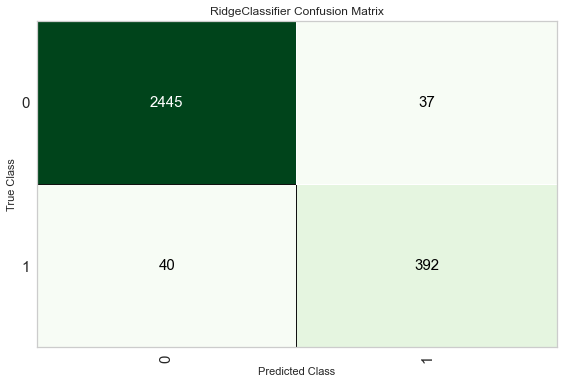

In [189]:
# plotando matriz de confusão
plot_model(ridge, plot='confusion_matrix')

Tem-se uma acurácia balanceada de 94,64% aproximadamente para o `RidgeClassifier`.

#### 5.5.2 - Otimizando os modelos

Quando um modelo é criado usando o ``create_model()``, ele usa os hiperparâmetros padrões para cada modelo. Para tentativa de tuning desses parâmetros, usamos a função ``tune_model()``.

Essa função faz o *tuning* dos parâmetros automaticamente usando `Random Grid Search`.

O parâmetro ``n_iter=250`` indica que a função irá testar 250 combinações aleatórias dos hiperparâmetros nos três modelos escolhidos.

In [190]:
# tuning de parâmetros
tuned_svm = tune_model(svm, optimize='BalancedAccuracy', n_iter=250, choose_better=True)

,AUC,Recall,Prec.,F1,BalancedAccuracy
0,0.0000,0.9320,0.9320,0.9320,0.9600
1,0.0000,0.8835,0.9579,0.9192,0.9383
2,0.0000,0.9320,0.9412,0.9366,0.9608
3,0.0000,0.8544,0.8544,0.8544,0.9142
4,0.0000,0.9135,0.8716,0.8920,0.9446
5,0.0000,0.9135,0.9314,0.9223,0.9507
6,0.0000,0.9038,0.8393,0.8704,0.9363
7,0.0000,0.9327,0.9327,0.9327,0.9603
8,0.0000,0.9223,0.8559,0.8879,0.9473
9,0.0000,0.8738,0.9000,0.8867,0.9282


In [191]:
# mostrando o modelo com hiperparâmetros 
tuned_svm

SGDClassifier(alpha=1e-06, average=False, class_weight=None,
              early_stopping=False, epsilon=0.1, eta0=0.2, fit_intercept=True,
              l1_ratio=0.8500000001, learning_rate='adaptive', loss='hinge',
              max_iter=1000, n_iter_no_change=5, n_jobs=-1,
              penalty='elasticnet', power_t=0.5, random_state=1234,
              shuffle=True, tol=0.001, validation_fraction=0.1, verbose=0,
              warm_start=False)

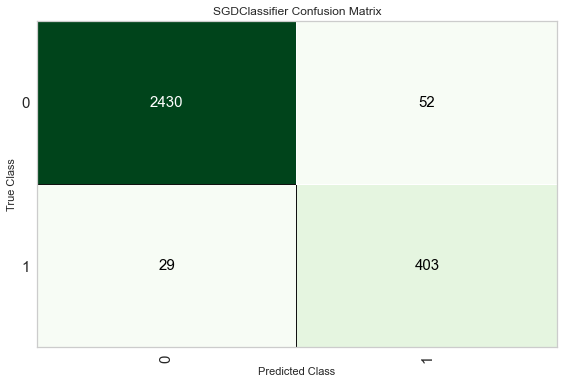

In [192]:
# plotando matriz de confusão com os hiperparâmetros otimizados
plot_model(tuned_svm, plot='confusion_matrix')

Não houve um ganho (acuráca balanceada de 95,63%) ao tentar ajustar os hiperparâmetros do modelo `SGDClassifier` em relação ao modelo padrão (*default*). 

In [193]:
# tuning de parâmetros
tuned_lda = tune_model(lda, optimize='BalancedAccuracy', n_iter = 250, choose_better=True)

,AUC,Recall,Prec.,F1,BalancedAccuracy
0,0.9894,0.9029,0.8774,0.8900,0.9402
1,0.9863,0.8738,0.9375,0.9045,0.9317
2,0.9850,0.9029,0.8774,0.8900,0.9402
3,0.9872,0.9029,0.8774,0.8900,0.9402
4,0.9812,0.9135,0.8962,0.9048,0.9472
5,0.9819,0.8846,0.9388,0.9109,0.9371
6,0.9837,0.8846,0.8846,0.8846,0.9319
7,0.9904,0.9038,0.9126,0.9082,0.9441
8,0.9689,0.8738,0.8491,0.8612,0.9230
9,0.9783,0.8447,0.8878,0.8657,0.9128


In [194]:
# mostrando o modelo com hiperparâmetros 
tuned_lda

LinearDiscriminantAnalysis(n_components=None, priors=None, shrinkage=0.01,
                           solver='lsqr', store_covariance=False, tol=0.0001)

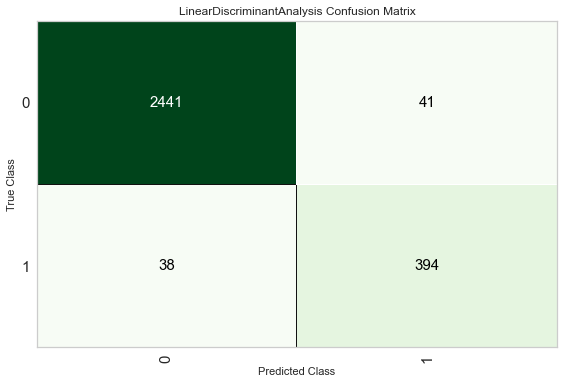

In [195]:
# plotando matriz de confusão
plot_model(tuned_lda, plot='confusion_matrix')

Neste caso, houve um pequeno ganho de acurácia balanceada (94,80%) em relação ao modelo padrão (*default*) ao se tentar alterações nos hiperparâmetros para o `LinearDiscriminantAnalysis`.

In [196]:
# tuning de parâmetros
tuned_ridge = tune_model(ridge, optimize='BalancedAccuracy', n_iter = 250, choose_better=True)

,AUC,Recall,Prec.,F1,BalancedAccuracy
0,0.0000,0.9029,0.8857,0.8942,0.9411
1,0.0000,0.8641,0.9368,0.8990,0.9268
2,0.0000,0.8932,0.8846,0.8889,0.9362
3,0.0000,0.9029,0.8774,0.8900,0.9402
4,0.0000,0.9038,0.9038,0.9038,0.9432
5,0.0000,0.8846,0.9388,0.9109,0.9371
6,0.0000,0.8750,0.8922,0.8835,0.9280
7,0.0000,0.8942,0.9300,0.9118,0.9410
8,0.0000,0.8738,0.8654,0.8696,0.9247
9,0.0000,0.8350,0.8866,0.8600,0.9079


In [197]:
# mostrando o modelo com hiperparâmetros 
tuned_ridge

RidgeClassifier(alpha=1.0, class_weight=None, copy_X=True, fit_intercept=True,
                max_iter=None, normalize=False, random_state=1234,
                solver='auto', tol=0.001)

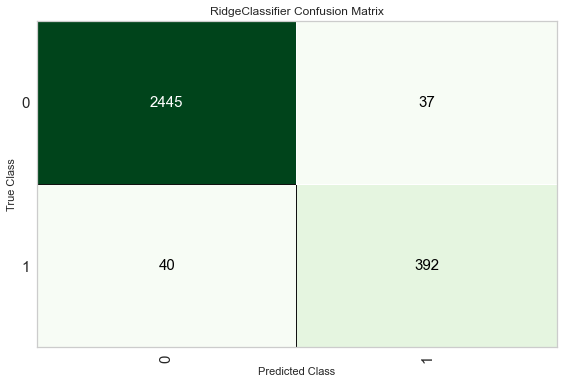

In [198]:
# plotando matriz de confusão
plot_model(tuned_ridge, plot='confusion_matrix')

Neste caso, não houve ganho de acurácia balanceada em relação ao modelo padrão (*default*) ao se tentar alterações nos hiperparâmetros para o `RidgeClassifier`.

#### 5.5.3 - Avaliando os modelos
O objetivo aqui é verificar a diferença de performance entre os resultados da validação cruzada e dos dados novos.
Nesta etapa, os modelos serão avaliados através dos 30% dos dados separados durante a configuração (*setup*) do Pycaret no item 5.3.

In [199]:
# fazendo previsões no modelo SGDClassifier
predict_model(svm);

,Model,AUC,Recall,Prec.,F1,BalancedAccuracy
0,SVM - Linear Kernel,0.9596,0.9306,0.9349,0.9327,0.9596


In [200]:
# fazendo previsões no modelo DecisionTreeClassifier
predict_model(tuned_lda);

,Model,AUC,Recall,Prec.,F1,BalancedAccuracy
0,Linear Discriminant Analysis,0.9818,0.9120,0.9057,0.9089,0.9478


In [201]:
# fazendo previsões no modelo ExtraTreesClassifier
predict_model(tuned_ridge);

,Model,AUC,Recall,Prec.,F1,BalancedAccuracy
0,Ridge Classifier,0.9463,0.9074,0.9138,0.9106,0.9463


Verifica-se que o modelo SVM (`SGDClassifier`) teve o melhor desempenho quanto a acurácia balanceada e o *Recall*.

#### 5.5.4 - Finalizando os modelos

Finalizar o modelo é o último passo do *workflow* normal no PyCaret.

Esse workflow irá conduzir o trabalho ao melhor modelo para fazer previsões em dados ainda não vistos.

A função `finalize_model()` realiza o *fit* no modelo, incluindo o conjunto de teste (30%) separado dentro do *PyCaret* anteriormente.

In [202]:
# finalizando SVM
final_svm = finalize_model(svm)

In [203]:
# finalizando LDA
final_lda = finalize_model(tuned_lda)

In [204]:
# finalizando RidgeClassifier
final_ridge = finalize_model(tuned_ridge)

#### 5.5.5 - Previsão com dados  ocultos (não vistos - *unseen*)

Agora, os modelos serão avaliados conforme os dados separados inicialmente (dados ocultados) em 5% do total do *dataset* final.

In [205]:
# fazendo previsão dos dados ocultos para o modelo SVM
resultado_svm = predict_model(final_svm, data=dados_validacao)  
# mostrando as primeiras entradas
resultado_svm.head()

,ocorrencia_classificacao,ocorrencia_latitude,ocorrencia_longitude,ocorrencia_cidade,ocorrencia_uf,ocorrencia_aerodromo,ocorrencia_hora,investigacao_aeronave_liberada,investigacao_status,divulgacao_relatorio_publicado,...,aeronave_fase_operacao,aeronave_tipo_operacao,aeronave_nivel_dano,fator_nome,fator_aspecto,fator_condicionante,fator_area,ocorrencia_mes,tem_fatalidade,Label
0,INCIDENTE,-23.496900,-47.445100,SOROCABA,SP,****,13:10:00,AUSENTE,FINALIZADA,NÃO,...,TÁXI,PRIVADA,LEVE,JULGAMENTO DE PILOTAGEM,DESEMPENHO DO SER HUMANO,OPERAÇÃO DA AERONAVE,FATOR OPERACIONAL,1,0,0
1,INCIDENTE GRAVE,-26.256389,-50.996389,PORTO UNIÃO,SC,****,10:30:00,SIM,FINALIZADA,SIM,...,ESPECIALIZADA,ESPECIALIZADA,NENHUM,MANUTENÇÃO DA AERONAVE,DESEMPENHO DO SER HUMANO,MANUTENÇÃO DA AERONAVE,FATOR OPERACIONAL,1,0,0
2,INCIDENTE,-23.276600,-51.279800,CAMBÉ,PR,****,14:30:00,AUSENTE,FINALIZADA,NÃO,...,ESPECIALIZADA,ESPECIALIZADA,NENHUM,JULGAMENTO DE PILOTAGEM,DESEMPENHO DO SER HUMANO,OPERAÇÃO DA AERONAVE,FATOR OPERACIONAL,3,0,0
3,ACIDENTE,-27.191944,-49.831389,RIO DO OESTE,SC,****,17:55:00,SIM,FINALIZADA,SIM,...,POUSO,INSTRUÇÃO,SUBSTANCIAL,SUPERVISÃO GERENCIAL,DESEMPENHO DO SER HUMANO,OPERAÇÃO DA AERONAVE,FATOR OPERACIONAL,4,0,0
4,ACIDENTE,-18.058333,-50.145833,ITUMBIARA,GO,****,17:20:00,SIM,FINALIZADA,SIM,...,DECOLAGEM,AGRÍCOLA,DESTRUÍDA,POUCA EXPERIÊNCIA DO PILOTO,DESEMPENHO DO SER HUMANO,OPERAÇÃO DA AERONAVE,FATOR OPERACIONAL,6,1,1


In [206]:
# apresentando a matriz de confusão para o modelo SVM
confusion_matrix(resultado_svm['tem_fatalidade'], resultado_svm['Label'])

array([[396,   2],
       [  3,  85]], dtype=int64)

A acurácia balanceada para os dados ocultos foi de 97,47% para o modelo SVM.

In [207]:
# fazendo previsão dos dados ocultos para o modelo LDA
resultado_lda = predict_model(final_lda, data=dados_validacao)  
# mostrando as primeiras entradas
resultado_lda.head()

,ocorrencia_classificacao,ocorrencia_latitude,ocorrencia_longitude,ocorrencia_cidade,ocorrencia_uf,ocorrencia_aerodromo,ocorrencia_hora,investigacao_aeronave_liberada,investigacao_status,divulgacao_relatorio_publicado,...,aeronave_tipo_operacao,aeronave_nivel_dano,fator_nome,fator_aspecto,fator_condicionante,fator_area,ocorrencia_mes,tem_fatalidade,Label,Score
0,INCIDENTE,-23.496900,-47.445100,SOROCABA,SP,****,13:10:00,AUSENTE,FINALIZADA,NÃO,...,PRIVADA,LEVE,JULGAMENTO DE PILOTAGEM,DESEMPENHO DO SER HUMANO,OPERAÇÃO DA AERONAVE,FATOR OPERACIONAL,1,0,0,1.0
1,INCIDENTE GRAVE,-26.256389,-50.996389,PORTO UNIÃO,SC,****,10:30:00,SIM,FINALIZADA,SIM,...,ESPECIALIZADA,NENHUM,MANUTENÇÃO DA AERONAVE,DESEMPENHO DO SER HUMANO,MANUTENÇÃO DA AERONAVE,FATOR OPERACIONAL,1,0,0,1.0
2,INCIDENTE,-23.276600,-51.279800,CAMBÉ,PR,****,14:30:00,AUSENTE,FINALIZADA,NÃO,...,ESPECIALIZADA,NENHUM,JULGAMENTO DE PILOTAGEM,DESEMPENHO DO SER HUMANO,OPERAÇÃO DA AERONAVE,FATOR OPERACIONAL,3,0,0,1.0
3,ACIDENTE,-27.191944,-49.831389,RIO DO OESTE,SC,****,17:55:00,SIM,FINALIZADA,SIM,...,INSTRUÇÃO,SUBSTANCIAL,SUPERVISÃO GERENCIAL,DESEMPENHO DO SER HUMANO,OPERAÇÃO DA AERONAVE,FATOR OPERACIONAL,4,0,0,1.0
4,ACIDENTE,-18.058333,-50.145833,ITUMBIARA,GO,****,17:20:00,SIM,FINALIZADA,SIM,...,AGRÍCOLA,DESTRUÍDA,POUCA EXPERIÊNCIA DO PILOTO,DESEMPENHO DO SER HUMANO,OPERAÇÃO DA AERONAVE,FATOR OPERACIONAL,6,1,1,1.0


In [208]:
# apresentando a matriz de confusão para o modelo Linear Discriminant Analysis
confusion_matrix(resultado_lda['tem_fatalidade'], resultado_lda['Label'])

array([[394,   4],
       [ 10,  78]], dtype=int64)

A acurácia balanceada para os dados ocultos foi de 93,69% para o `Linear Discriminant Analysis`.

In [209]:
# fazendo previsão dos dados ocultos para o modelo LDA
resultado_ridge = predict_model(final_ridge, data=dados_validacao)    
# mostrando as primeiras entradas
resultado_ridge.head()

,ocorrencia_classificacao,ocorrencia_latitude,ocorrencia_longitude,ocorrencia_cidade,ocorrencia_uf,ocorrencia_aerodromo,ocorrencia_hora,investigacao_aeronave_liberada,investigacao_status,divulgacao_relatorio_publicado,...,aeronave_fase_operacao,aeronave_tipo_operacao,aeronave_nivel_dano,fator_nome,fator_aspecto,fator_condicionante,fator_area,ocorrencia_mes,tem_fatalidade,Label
0,INCIDENTE,-23.496900,-47.445100,SOROCABA,SP,****,13:10:00,AUSENTE,FINALIZADA,NÃO,...,TÁXI,PRIVADA,LEVE,JULGAMENTO DE PILOTAGEM,DESEMPENHO DO SER HUMANO,OPERAÇÃO DA AERONAVE,FATOR OPERACIONAL,1,0,0
1,INCIDENTE GRAVE,-26.256389,-50.996389,PORTO UNIÃO,SC,****,10:30:00,SIM,FINALIZADA,SIM,...,ESPECIALIZADA,ESPECIALIZADA,NENHUM,MANUTENÇÃO DA AERONAVE,DESEMPENHO DO SER HUMANO,MANUTENÇÃO DA AERONAVE,FATOR OPERACIONAL,1,0,0
2,INCIDENTE,-23.276600,-51.279800,CAMBÉ,PR,****,14:30:00,AUSENTE,FINALIZADA,NÃO,...,ESPECIALIZADA,ESPECIALIZADA,NENHUM,JULGAMENTO DE PILOTAGEM,DESEMPENHO DO SER HUMANO,OPERAÇÃO DA AERONAVE,FATOR OPERACIONAL,3,0,0
3,ACIDENTE,-27.191944,-49.831389,RIO DO OESTE,SC,****,17:55:00,SIM,FINALIZADA,SIM,...,POUSO,INSTRUÇÃO,SUBSTANCIAL,SUPERVISÃO GERENCIAL,DESEMPENHO DO SER HUMANO,OPERAÇÃO DA AERONAVE,FATOR OPERACIONAL,4,0,0
4,ACIDENTE,-18.058333,-50.145833,ITUMBIARA,GO,****,17:20:00,SIM,FINALIZADA,SIM,...,DECOLAGEM,AGRÍCOLA,DESTRUÍDA,POUCA EXPERIÊNCIA DO PILOTO,DESEMPENHO DO SER HUMANO,OPERAÇÃO DA AERONAVE,FATOR OPERACIONAL,6,1,1


In [210]:
# apresentando a matriz de confusão para o modelo Ridge Classifier
confusion_matrix(resultado_ridge['tem_fatalidade'], resultado_ridge['Label'])

array([[395,   3],
       [ 10,  78]], dtype=int64)

A acurácia balanceada para os dados ocultos foi de 93,69% para o `Ridge Classifier`.